# Script Analysis Environment

This notebook contains the implementation of deep learning methodology for ancient script stylistic analysis, focusing on relationships between Indus, Proto-Cuneiform, Proto-Elamite and Naxi-Dongba writing systems.

# **1. Environment Setup and Dependencies**

In [ ]:
# Install required packages
!pip install torch torchvision timm transformers matplotlib scikit-learn opencv-python pandas seaborn umap-learn Pillow fontTools beautifulsoup4 requests tqdm

# Import necessary libraries
import os
import cv2
import torch
import shutil
import timm
import random
import base64
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import zipfile
from io import BytesIO

from datetime import datetime
from tqdm.notebook import tqdm
from bs4 import BeautifulSoup
from google.colab import drive, files

from torchvision import transforms
import torchvision.transforms.functional as TF
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split

from PIL import Image, ImageDraw, ImageFont, ImageFilter, ImageEnhance, ImageOps, ImageFilter
from fontTools.ttLib import TTFont

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics.pairwise import cosine_similarity

from timm.data import resolve_data_config
from timm.loss import LabelSmoothingCrossEntropy

# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Mount Google Drive to access your dataset
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

# **2: Data Loading and Preprocessing Functions**

## 2.1 Indus Script Acquisition

Implementation of an authenticated web scraper for the Indus corpus with frequency-based filtering.


---



**Technical Implementation**
- **HTTP Authentication**: Base64-encoded Basic Auth header implementation (username:password)
- **HTML Processing**: BeautifulSoup parser extracting tabular data with column-specific targeting
- **Selection Logic**: Integer-based frequency filtering (threshold > 2) with exception handling
- **Network Pipeline**: Persistent session management with streaming binary data transfer
- **Image Extraction**: URL composition from relative paths with content-type validation
- **Storage Implementation**: Filesystem operations with path normalization and atomic writes
- **Naming Convention**: Sign code preservation in filename with consistent extension formatting

This pipeline establishes the statistically significant subset of the Indus corpus (frequency > 2) required for feature extraction model training.

In [ ]:
# Ensure directory exists
def ensure_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Created directory: {directory}")
    else:
        print(f"Directory already exists: {directory}")

# Set output directory in Google Drive
output_dir = "/content/drive/MyDrive/script_analysis/indus"
ensure_dir(output_dir)

# GitHub repository details
repo_owner = "oohalakkadi"
repo_name = "signaturework"
branch = "main"
file_path = "data/indus/ICIT.html"

# Create the raw GitHub URL for the HTML file
raw_url = f"https://raw.githubusercontent.com/{repo_owner}/{repo_name}/{branch}/{file_path}"
print(f"Fetching HTML file from: {raw_url}")

# Download the HTML file
response = requests.get(raw_url)
if response.status_code != 200:
    print(f"Failed to fetch HTML file. Status code: {response.status_code}")
    print(f"Response: {response.text}")
    raise Exception("Could not download HTML file from GitHub")

# Save the HTML file locally for processing
local_html_path = os.path.join(output_dir, "ICIT.html")
with open(local_html_path, "wb") as file:
    file.write(response.content)
print(f"Downloaded HTML file to: {local_html_path}")

# Base URL for the Indus website
base_url = "https://www.indus.epigraphica.de/"

# Authentication details for the Indus website
AUTH_USERNAME = "icit"
AUTH_PASSWORD = "seal123"
AUTH_HEADER = {
    "Authorization": "Basic " + base64.b64encode(f"{AUTH_USERNAME}:{AUTH_PASSWORD}".encode()).decode()
}

# Read the HTML file
print("Parsing HTML file...")
with open(local_html_path, "r", encoding="utf-8") as file:
    soup = BeautifulSoup(file, "html.parser")

# Find all table rows (skip the header)
rows = soup.find_all("tr")[1:]
print(f"Found {len(rows)} rows in the table")

# Collect sign data
sign_data = []
for row in rows:
    cols = row.find_all("td")

    if len(cols) < 12:
        continue  # Skip malformed rows

    # Extract sign code (1st column)
    sign_code = cols[0].text.strip()

    # Extract image source (7th column)
    img_tag = cols[6].find("img")
    if img_tag:
        img_src = img_tag["src"]
        img_url = base_url + img_src  # Construct full image URL

        # Extract frequency (12th column)
        try:
            frequency = int(cols[11].text.strip())
        except ValueError:
            continue  # Skip invalid frequency values

        # Store only if frequency > 2
        if frequency > 2:
            sign_data.append((sign_code, img_url))

print(f"Found {len(sign_data)} signs with frequency > 2")

# Download images with a progress bar
print(f"Downloading {len(sign_data)} images...")

session = requests.Session()
session.headers.update(AUTH_HEADER)  # Add Basic Auth header to all requests

for sign_code, img_url in tqdm(sign_data, desc="Downloading"):
    img_filename = os.path.join(output_dir, f"{sign_code}.jpg")

    response = session.get(img_url, stream=True)
    if response.status_code == 200:
        with open(img_filename, "wb") as img_file:
            img_file.write(response.content)
    else:
        print(f"Failed to download: {img_url} - Status {response.status_code}")

print("Download complete! All images are saved in:", output_dir)

# List the first few downloaded files as verification
downloaded_files = [f for f in os.listdir(output_dir) if f.endswith('.jpg')]
print(f"Downloaded {len(downloaded_files)} image files")
if downloaded_files:
    print(f"Sample files: {', '.join(downloaded_files[:5])}" +
          (f"... and {len(downloaded_files)-5} more" if len(downloaded_files) > 5 else ""))

Created directory: /content/drive/MyDrive/script_analysis/indus
Fetching HTML file from: https://raw.githubusercontent.com/oohalakkadi/signaturework/main/data/indus/ICIT.html
Downloaded HTML file to: /content/drive/MyDrive/script_analysis/indus/ICIT.html
Parsing HTML file...
Found 715 rows in the table
Found 391 signs with frequency > 2


Downloading:   0%|          | 0/391 [00:00<?, ?it/s]

Download complete! All images are saved in: /content/drive/MyDrive/script_analysis/indus
Downloaded 391 image files
Sample files: 1.jpg, 2.jpg, 3.jpg, 4.jpg, 5.jpg... and 386 more


## 2.2 Proto-Cuneiform Script Acquisition



Retrieval of the standardized Proto-Cuneiform sign corpus from CDLI GitHub repository.

- **Repository**: cdli-gh/proto-cuneiform_signs
- **Operation**: Clone repository and extract JPG images from archsigns directory
- **Destination**: Google Drive at /content/drive/MyDrive/script_analysis/proto_cuneiform/

Establishes the Proto-Cuneiform dataset.

In [ ]:
!git clone https://github.com/cdli-gh/proto-cuneiform_signs.git
!mkdir -p /content/drive/MyDrive/script_analysis/proto_cuneiform/
!cp proto-cuneiform_signs/archsigns/*.jpg /content/drive/MyDrive/script_analysis/proto_cuneiform/

Cloning into 'proto-cuneiform_signs'...
remote: Enumerating objects: 2104, done.
remote: Counting objects: 100% (2104/2104), done.
remote: Compressing objects: 100% (2077/2077), done.
remote: Total 2104 (delta 30), reused 2093 (delta 27), pack-reused 0 (from 0)
Receiving objects: 100% (2104/2104), 7.09 MiB | 15.86 MiB/s, done.
Resolving deltas: 100% (30/30), done.


## 2.3 Proto-Elamite Script Acquisition

Retrieval of Proto-Elamite sign corpus from SFU Natural Language Lab repository.

- **Repository**: sfu-natlang/pe-decipher-toolkit
- **Operation**: Clone repository and extract PNG images from both main forms and numerical signs, sourced from CDLI
- **Sources**: PE_mainforms directory (standard signs) and PE_num directory (numerical notation)
- **Destination**: Google Drive at /content/drive/MyDrive/script_analysis/proto_elamite/

Establishes the Proto-Elamite dataset containing both standard and numerical signs.

In [ ]:
!git clone https://github.com/sfu-natlang/pe-decipher-toolkit.git
!mkdir -p /content/drive/MyDrive/script_analysis/proto_elamite/
!cp pe-decipher-toolkit/pngs/PE_mainforms/*.png /content/drive/MyDrive/script_analysis/proto_elamite/
!cp pe-decipher-toolkit/pngs/PE_num/*.png /content/drive/MyDrive/script_analysis/proto_elamite/

Cloning into 'pe-decipher-toolkit'...
remote: Enumerating objects: 1560, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 1560 (delta 0), reused 0 (delta 0), pack-reused 1557 (from 1)
Receiving objects: 100% (1560/1560), 4.58 MiB | 19.13 MiB/s, done.
Resolving deltas: 100% (52/52), done.


## 2.4 Naxi Dongba Script Acquisition and Generation


Implementation of font-based character rendering pipeline for Naxi Dongba script dataset creation.

- **Source**: BabelStoneNaxiLLC.ttf font file containing standardized Dongba glyphs
- **Unicode Range**: U+E000 to U+E849 (2,122 Dongba characters in Private Use Area)
- **Rendering Process**:
  - Character-by-character rendering with centered positioning
  - Consistent 224×224px dimensions for neural network compatibility
  - PNG format with lossless compression
- **Visual Verification**: Sample character display with Unicode code point labeling
- **Naming Convention**: Unicode-based filenames (dongba_{hex_code}.png)

Creates programmatically generated Naxi Dongba glyph dataset with standardized rendering parameters for script comparison analysis.

Font loaded successfully: BabelStoneNaxiLLC.ttf
Will generate images for 2122 characters (U+E000 to U+E849)


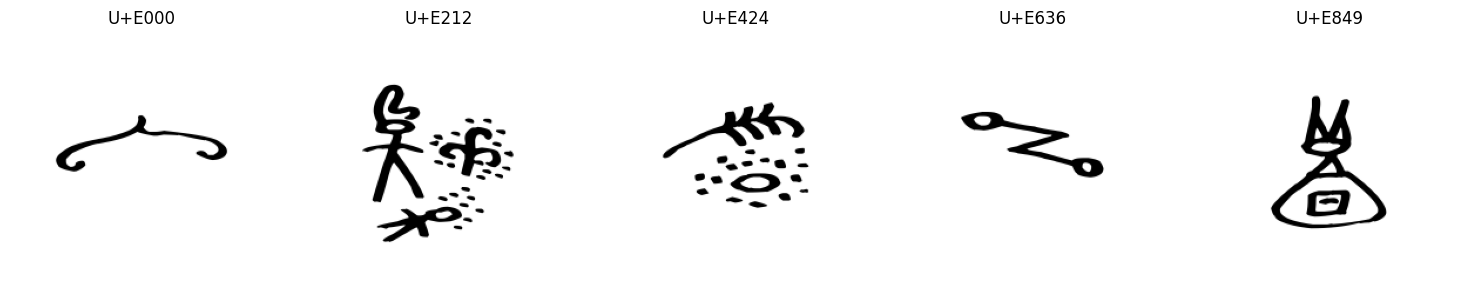

Generating images:   0%|          | 0/2122 [00:00<?, ?it/s]

Created 2122 character images in /content/drive/MyDrive/script_analysis/naxi_dongba/


'/content/drive/MyDrive/script_analysis/naxi_dongba/'

In [ ]:
def ensure_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Created directory: {directory}")
    else:
        print(f"Directory already exists: {directory}")

def download_font_from_github(output_path):
    """Download the TTF font file from GitHub repository"""
    # GitHub repository details
    repo_owner = "oohalakkadi"
    repo_name = "signaturework"
    branch = "main"
    font_path = "data/naxi/BabelStoneNaxiLLC.ttf"

    # Create the raw GitHub URL for the font file
    raw_url = f"https://raw.githubusercontent.com/{repo_owner}/{repo_name}/{branch}/{font_path}"
    print(f"Downloading font from: {raw_url}")

    # Download the font file
    response = requests.get(raw_url)
    if response.status_code != 200:
        print(f"Failed to fetch font file. Status code: {response.status_code}")
        raise Exception("Could not download font file from GitHub")

    # Save the font file locally
    with open(output_path, "wb") as file:
        file.write(response.content)
    print(f"Downloaded font to: {output_path}")
    return output_path

def char_to_image(char, font, image_size=224, bg_color=(255, 255, 255), text_color=(0, 0, 0)):
    img = Image.new('RGB', (image_size, image_size), color=bg_color)
    draw = ImageDraw.Draw(img)

    left, top, right, bottom = font.getbbox(char)
    text_width = right - left
    text_height = bottom - top

    # center text
    position = ((image_size - text_width) // 2 - left, (image_size - text_height) // 2 - top)

    draw.text(position, char, fill=text_color, font=font)

    return img

# set range within Dongba font
def create_dongba_dataset(font_path, output_dir, start_code=0xE000, end_code=0xE849, image_size=224):
    ensure_dir(output_dir)

    font_size = int(image_size * 0.7)
    try:
        font = ImageFont.truetype(font_path, font_size)
        print(f"Font loaded successfully: {font_path}")
    except Exception as e:
        print(f"Error loading font {font_path}: {e}")
        return

    char_list = [chr(code) for code in range(start_code, end_code + 1)]
    print(f"Will generate images for {len(char_list)} characters (U+{start_code:04X} to U+{end_code:04X})")

    # Get font name for naming files
    font_name = os.path.splitext(os.path.basename(font_path))[0]

    # Display a few sample characters
    plt.figure(figsize=(15, 3))
    sample_indices = np.linspace(0, len(char_list)-1, 5, dtype=int)

    for i, idx in enumerate(sample_indices):
        char = char_list[idx]
        img = char_to_image(char, font, image_size=image_size)
        plt.subplot(1, 5, i+1)
        plt.imshow(np.array(img))
        plt.title(f"U+{ord(char):04X}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Create an image for each character with a progress bar
    for i, char in tqdm(enumerate(char_list), total=len(char_list), desc="Generating images"):
        try:
            # Generate a safe filename
            char_code = f"{ord(char):04X}"
            filename = f"dongba_{char_code}.png"

            # Render the character
            img = char_to_image(char, font, image_size=image_size)

            # Save the image
            img.save(os.path.join(output_dir, filename))

        except Exception as e:
            print(f"Error processing character U+{ord(char):04X}: {e}")

    print(f"Created {len(char_list)} character images in {output_dir}")
    return output_dir

# Set output directories
output_dir = '/content/drive/MyDrive/script_analysis/naxi_dongba/'
ensure_dir(output_dir)

# Temp location for downloaded font
temp_font_path = '/content/BabelStoneNaxiLLC.ttf'

# Download the font file from GitHub
downloaded_font_path = download_font_from_github(temp_font_path)

# Create the dataset with the specified Unicode range (U+E000 to U+E849)
create_dongba_dataset(
    font_path=downloaded_font_path,
    output_dir=output_dir,
    start_code=0xE000,
    end_code=0xE849,
    image_size=224
)

# Count generated files as verification
generated_files = [f for f in os.listdir(output_dir) if f.startswith('dongba_') and f.endswith('.png')]
print(f"\nGeneration complete! {len(generated_files)} images saved to: {output_dir}")

# Force sync to Google Drive
print("Syncing files to Google Drive...")
try:
    with open('/content/drive/MyDrive/__force_sync__', 'w') as f:
        f.write('')
    os.remove('/content/drive/MyDrive/__force_sync__')
except:
    pass  # Ignore errors with the sync file
print("Sync complete.")

## 2.5 Old Naxi (Dongba) Script Acquisition


In [ ]:
!git clone https://github.com/infinite-hwb/VGTS.git
!mkdir -p /content/drive/MyDrive/script_analysis/old_naxi/
!cp VGTS/"DATA/DBH dataset"/"support image gallery/images"/*.jpg /content/drive/MyDrive/script_analysis/old_naxi/

Cloning into 'VGTS'...
remote: Enumerating objects: 583, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 583 (delta 10), reused 0 (delta 0), pack-reused 541 (from 1)
Receiving objects: 100% (583/583), 139.71 MiB | 16.40 MiB/s, done.
Resolving deltas: 100% (58/58), done.


## 2.6 TYC Scripts Acquisition

### Ba-Shu Dataset Acquisition (symbols transcribed from Sanxingdui Museum)

In [ ]:
import os
import requests
import json

def ensure_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
    print(f"Directory ready: {directory}")

# Set up destination directory
drive_bashu_dir = '/content/drive/MyDrive/script_analysis/ba-shu/'
ensure_dir(drive_bashu_dir)

# GitHub repository details
repo_owner = "oohalakkadi"
repo_name = "signaturework"
branch = "main"
folder_path = "data/tyc/ba-shu"

# Use GitHub API to list the contents of the folder
api_url = f"https://api.github.com/repos/{repo_owner}/{repo_name}/contents/{folder_path}?ref={branch}"
print(f"Fetching file list from: {api_url}")

response = requests.get(api_url)
if response.status_code != 200:
    print(f"Failed to fetch repository contents. Status code: {response.status_code}")
    print(f"Response: {response.text}")
else:
    # Process the files
    files = json.loads(response.text)
    print(f"Found {len(files)} files in the repository folder")

    # Download each file
    for file in files:
        if file['type'] == 'file':  # Only process files, not subdirectories
            file_url = file['download_url']
            file_name = file['name']

            print(f"Downloading: {file_name}")

            # Download the file content
            file_response = requests.get(file_url)
            if file_response.status_code == 200:
                # Save to Google Drive
                destination_path = os.path.join(drive_bashu_dir, file_name)
                with open(destination_path, 'wb') as f:
                    f.write(file_response.content)
                print(f"Saved: {file_name}")
            else:
                print(f"Failed to download {file_name}. Status code: {file_response.status_code}")

    # Force sync to Google Drive
    print("Syncing files to Google Drive...")
    with open('/content/drive/MyDrive/__force_sync__', 'w') as f:
        f.write('')
    os.remove('/content/drive/MyDrive/__force_sync__')

    # Verify the files were downloaded
    downloaded_files = os.listdir(drive_bashu_dir)
    print(f"\nDownload complete! {len(downloaded_files)} files saved in: {drive_bashu_dir}")
    print(f"Files: {', '.join(downloaded_files[:5])}" +
          (f"... and {len(downloaded_files)-5} more" if len(downloaded_files) > 5 else ""))

Directory ready: /content/drive/MyDrive/script_analysis/ba-shu/
Fetching file list from: https://api.github.com/repos/oohalakkadi/signaturework/contents/data/tyc/ba-shu?ref=main
Found 281 files in the repository folder
Downloading: Ba-Shu_scripts_(anthropomorphic_symbols)__1ged.png
Saved: Ba-Shu_scripts_(anthropomorphic_symbols)__1ged.png
Downloading: Ba-Shu_scripts_(anthropomorphic_symbols)__2918.png
Saved: Ba-Shu_scripts_(anthropomorphic_symbols)__2918.png
Downloading: Ba-Shu_scripts_(anthropomorphic_symbols)__7sh9.png
Saved: Ba-Shu_scripts_(anthropomorphic_symbols)__7sh9.png
Downloading: Ba-Shu_scripts_(anthropomorphic_symbols)__9mup.png
Saved: Ba-Shu_scripts_(anthropomorphic_symbols)__9mup.png
Downloading: Ba-Shu_scripts_(anthropomorphic_symbols)__celh.png
Saved: Ba-Shu_scripts_(anthropomorphic_symbols)__celh.png
Downloading: Ba-Shu_scripts_(anthropomorphic_symbols)__lh2g.png
Saved: Ba-Shu_scripts_(anthropomorphic_symbols)__lh2g.png
Downloading: Ba-Shu_scripts_(anthropomorphic_symb

### Classical Yi Data Acquisition

In [ ]:
import os
import zipfile
import requests
import random
from io import BytesIO
from google.colab import drive

# Mount Google Drive with verification
drive.mount('/content/drive')
if not os.path.exists('/content/drive/MyDrive'):
    print("ERROR: Google Drive was not properly mounted!")
    exit(1)
else:
    print("Google Drive successfully mounted")

# Set up destination directory in Google Drive
yi_dir = "/content/drive/MyDrive/script_analysis/yi/"
try:
    os.makedirs(yi_dir, exist_ok=True)
    print(f"Directory created or already exists at: {yi_dir}")
except Exception as e:
    print(f"ERROR creating directory: {e}")
    exit(1)

# Define the URL
url = "https://download.scidb.cn/download?fileId=8f5feddd6987cf95a887c80e6de44c0a&path=/V2/data.zip&fileName=data.zip"

# Download the ZIP file
print("Downloading ZIP file...")
try:
    response = requests.get(url, stream=True)
    response.raise_for_status()  # Raise exception for HTTP errors
    print("Download successful")
except Exception as e:
    print(f"ERROR downloading file: {e}")
    exit(1)

# Process the ZIP file
try:
    zip_file = zipfile.ZipFile(BytesIO(response.content))

    # List all files in the ZIP to help debug
    all_files = zip_file.namelist()
    print(f"ZIP contains {len(all_files)} files")
    print(f"First 5 files: {all_files[:5] if all_files else 'No files found'}")

    # Extract subfolders and select one PNG per subfolder
    print("Extracting one PNG per subfolder...")
    subfolder_files = {}

    for file in all_files:
        if file.lower().endswith('.png'):
            folder = os.path.dirname(file)  # Get subfolder name
            if folder not in subfolder_files:
                subfolder_files[folder] = []
            subfolder_files[folder].append(file)

    print(f"Found {len(subfolder_files)} folders with PNG files")

    # Select one random PNG from each subfolder and save
    selected_count = 0
    for folder, files in subfolder_files.items():
        chosen_file = random.choice(files)
        file_path = os.path.join(yi_dir, os.path.basename(chosen_file))

        try:
            with zip_file.open(chosen_file) as source, open(file_path, "wb") as target:
                target.write(source.read())
            selected_count += 1
            print(f"Saved: {file_path}")
        except Exception as e:
            print(f"ERROR saving file {chosen_file}: {e}")

    print(f"Extraction complete! {selected_count} images saved in: {yi_dir}")

    # Verify files were created
    saved_files = os.listdir(yi_dir)
    print(f"Files in destination directory: {len(saved_files)}")
    if saved_files:
        print(f"First few files: {saved_files[:5]}")
    else:
        print("No files found in destination directory!")

except Exception as e:
    print(f"ERROR processing ZIP file: {e}")
    exit(1)

# Force sync to Google Drive
print("Syncing files to Google Drive...")
# This command helps flush changes to Drive
!cp /dev/null /content/drive/MyDrive/__force_sync__
print("Sync complete. Files should now be visible in your Google Drive.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive successfully mounted
Directory created or already exists at: /content/drive/MyDrive/script_analysis/yi/
Download successful
ZIP contains 430864 files
First 5 files: ['data/', 'data/AC01/', 'data/AC01/AC01_1516182470.6141670.png', 'data/AC01/AC01_1516182471.2102199.png', 'data/AC01/AC01_1516182471.8364618.png']
Extracting one PNG per subfolder...
Found 2922 folders with PNG files
Saved: /content/drive/MyDrive/script_analysis/yi/AC01_1516182503.2835712.png
Saved: /content/drive/MyDrive/script_analysis/yi/1554816647.625123-AC03.png
Saved: /content/drive/MyDrive/script_analysis/yi/1554816748.201153-AC04.png
Saved: /content/drive/MyDrive/script_analysis/yi/1554429620.215738-AC05.png
Saved: /content/drive/MyDrive/script_analysis/yi/1554348096.426669-AC06.png
Saved: /content/drive/MyDrive/script_analysis/yi/1554816673.6391325-AC07.png
Saved: /content/dr

### TYC Data Merging

Project Structure

In [ ]:
import os
import cv2
import numpy as np
import torch
import torchvision.transforms as transforms
import shutil
from PIL import Image
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from google.colab import drive

# Set paths
YI_PATH = '/content/drive/MyDrive/script_analysis/yi/'
BA_SHU_PATH = '/content/drive/MyDrive/script_analysis/ba-shu/'
OLD_NAXI_PATH = '/content/drive/MyDrive/script_analysis/old_naxi/'
TYC_PATH = '/content/drive/MyDrive/script_analysis/tyc/'

# Create TYC directory and subfolders
def setup_directories():
    """Create the necessary directory structure for the TYC dataset"""
    os.makedirs(TYC_PATH, exist_ok=True)
    os.makedirs(os.path.join(TYC_PATH, 'yi'), exist_ok=True)
    os.makedirs(os.path.join(TYC_PATH, 'ba-shu'), exist_ok=True)
    os.makedirs(os.path.join(TYC_PATH, 'old_naxi'), exist_ok=True)
    print(f"Created TYC directory structure at {TYC_PATH}")

# Denoising function (from your existing code)
def denoise_image(image):
    """
    Apply denoising to the image.
    This function combines multiple methods to handle different types of noise.
    """
    # Convert PIL to numpy for OpenCV operations
    np_image = np.array(image)

    # Convert to grayscale if it's a color image (for processing)
    is_color = len(np_image.shape) == 3 and np_image.shape[2] == 3
    if is_color:
        gray = cv2.cvtColor(np_image, cv2.COLOR_RGB2GRAY)
    else:
        gray = np_image.copy()

    # Apply adaptive thresholding to handle uneven lighting (for binary glyph images)
    binary = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY, 11, 2
    )

    # Apply morphological operations to remove small noise
    kernel = np.ones((2, 2), np.uint8)
    morphed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

    # Apply non-local means denoising (better preserves edges than Gaussian)
    denoised = cv2.fastNlMeansDenoising(morphed, None, 10, 7, 21)

    # Convert back to original format
    if is_color:
        # Create a 3-channel image from the denoised grayscale
        result = np.stack([denoised] * 3, axis=2)
    else:
        result = denoised

    return Image.fromarray(result)

# Function to load image paths from a directory
def load_image_paths(directory):
    """Loads all valid image paths from a directory"""
    image_paths = []
    valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff']

    if not os.path.exists(directory):
        print(f"Warning: Directory {directory} does not exist!")
        return image_paths

    for root, _, files in os.walk(directory):
        for file in files:
            if any(file.lower().endswith(ext) for ext in valid_extensions):
                image_paths.append(os.path.join(root, file))

    return image_paths

# Start by setting up directory structure
setup_directories()

# Count files in each source directory
yi_files = load_image_paths(YI_PATH)
ba_shu_files = load_image_paths(BA_SHU_PATH)
old_naxi_files = load_image_paths(OLD_NAXI_PATH)

print(f"Original dataset counts:")
print(f"Yi: {len(yi_files)} images")
print(f"Ba-shu: {len(ba_shu_files)} images")
print(f"Old Naxi: {len(old_naxi_files)} images")
print(f"Target count per script: ~{len(yi_files)} images")

Created TYC directory structure at /content/drive/MyDrive/script_analysis/tyc/
Original dataset counts:
Yi: 2922 images
Ba-shu: 281 images
Old Naxi: 253 images
Target count per script: ~2922 images


Processing Classical Yi

In [ ]:
def process_yi_dataset():
    """
    Copy Yi dataset files to the TYC structure.
    No processing needed as these files are already in good condition.
    """
    yi_paths = load_image_paths(YI_PATH)
    target_dir = os.path.join(TYC_PATH, 'yi')

    print(f"Copying {len(yi_paths)} Yi images to {target_dir}...")

    for i, path in enumerate(tqdm(yi_paths)):
        # Get the filename
        filename = os.path.basename(path)
        # Ensure unique filenames
        target_path = os.path.join(target_dir, f"yi_{i:05d}_{filename}")
        # Copy the file
        shutil.copy2(path, target_path)

    print(f"Yi processing complete. {len(yi_paths)} images copied.")
    return len(yi_paths)

Processing Old Naxi

In [ ]:
def gentle_denoise_image(image):
    """
    Apply gentler denoising to the image to preserve more details.
    """
    # Convert PIL to numpy for OpenCV operations
    np_image = np.array(image)

    # Convert to grayscale if it's a color image (for processing)
    is_color = len(np_image.shape) == 3 and np_image.shape[2] == 3
    if is_color:
        gray = cv2.cvtColor(np_image, cv2.COLOR_RGB2GRAY)
    else:
        gray = np_image.copy()

    # Apply bilateral filter for edge-preserving smoothing
    smoothed = cv2.bilateralFilter(gray, 9, 75, 75)

    # Apply a gentler non-local means denoising
    h_param = 7  # Lower value = less denoising (was 10)
    denoised = cv2.fastNlMeansDenoising(smoothed, None, h_param, 7, 21)

    # Skip aggressive thresholding and use only if needed
    if np.std(denoised) < 40:  # Only apply if the image has low contrast
        binary = cv2.adaptiveThreshold(
            denoised, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY, 15, 5  # More gentle parameters
        )
        result_gray = binary
    else:
        result_gray = denoised

    # Convert back to original format
    if is_color:
        # Create a 3-channel image from the denoised grayscale
        result = np.stack([result_gray] * 3, axis=2)
    else:
        result = result_gray

    return Image.fromarray(result)

def process_old_naxi_dataset(target_count=None):
    """
    Process Old Naxi dataset files:
    1. Apply gentle denoising
    2. Copy to the TYC structure
    3. Augment to reach target count if needed
    """
    old_naxi_paths = load_image_paths(OLD_NAXI_PATH)
    target_dir = os.path.join(TYC_PATH, 'old_naxi')

    # Use Yi count as default target
    if target_count is None:
        yi_files = load_image_paths(YI_PATH)
        target_count = len(yi_files)

    print(f"Processing {len(old_naxi_paths)} Old Naxi images...")

    # Process original files
    processed_files = []
    for i, path in enumerate(tqdm(old_naxi_paths)):
        try:
            # Load image
            img = Image.open(path).convert('RGB')
            # Apply gentle denoising
            denoised_img = gentle_denoise_image(img)
            # Save denoised image with unique filename
            filename = os.path.basename(path)
            target_path = os.path.join(target_dir, f"old_naxi_orig_{i:05d}_{filename}")
            denoised_img.save(target_path)
            processed_files.append(target_path)
        except Exception as e:
            print(f"Error processing {path}: {e}")

    # Determine how many more images we need to generate
    num_synthetic = max(0, target_count - len(processed_files))

    if num_synthetic > 0:
        print(f"Need to generate {num_synthetic} additional Old Naxi images to reach target count")
        # Use the same augmentation approach as Ba-shu
        augment_images(processed_files, target_dir, num_synthetic, prefix="old_naxi_aug")

    # Count the processed files
    final_files = load_image_paths(target_dir)
    print(f"Old Naxi processing complete. {len(final_files)} images processed/generated.")
    return len(final_files)

def augment_images(image_paths, target_dir, num_to_generate, prefix="aug"):
    """Generic function to augment a set of images"""
    # Load source images
    source_images = []
    for path in image_paths:
        try:
            img = Image.open(path).convert('RGB')
            source_images.append(img)
        except Exception as e:
            print(f"Error loading {path}: {e}")

    if not source_images:
        print("No images to augment!")
        return 0

    # Generate augmented images
    print(f"Generating {num_to_generate} augmented images...")
    for i in tqdm(range(num_to_generate)):
        # Pick a random image
        base_img = random.choice(source_images).copy()

        # Apply advanced augmentation
        intensity = random.uniform(0.5, 0.8)
        augmented = advanced_augment(base_img, intensity)

        # Save the augmented image
        save_path = os.path.join(target_dir, f"{prefix}_{i:05d}.png")
        augmented.save(save_path)

    return num_to_generate

# Visual comparison function for denoising
def compare_denoising_methods(sample_path):
    """Compare original denoising with gentle denoising"""
    original_img = Image.open(sample_path).convert('RGB')

    # Original strong denoising (from your code)
    def original_denoise(image):
        np_image = np.array(image)
        is_color = len(np_image.shape) == 3 and np_image.shape[2] == 3
        if is_color:
            gray = cv2.cvtColor(np_image, cv2.COLOR_RGB2GRAY)
        else:
            gray = np_image.copy()
        binary = cv2.adaptiveThreshold(
            gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY, 11, 2
        )
        kernel = np.ones((2, 2), np.uint8)
        morphed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
        denoised = cv2.fastNlMeansDenoising(morphed, None, 10, 7, 21)
        if is_color:
            result = np.stack([denoised] * 3, axis=2)
        else:
            result = denoised
        return Image.fromarray(result)

    # Apply both methods
    strong_denoised = original_denoise(original_img)
    gentle_denoised = gentle_denoise_image(original_img)

    # Display comparison
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(original_img)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(strong_denoised)
    plt.title("Strong Denoising (Original)")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(gentle_denoised)
    plt.title("Gentle Denoising (Improved)")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

Processing Ba-Shu (with StyleGAN augmentation)

In [ ]:
import os
import cv2
import numpy as np
import random
import shutil
from PIL import Image, ImageOps, ImageFilter, ImageEnhance
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

def load_image_paths(directory):
    """Loads all valid image paths from a directory"""
    image_paths = []
    valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff']

    if not os.path.exists(directory):
        print(f"Warning: Directory {directory} does not exist!")
        return image_paths

    for root, _, files in os.walk(directory):
        for file in files:
            if any(file.lower().endswith(ext) for ext in valid_extensions):
                image_paths.append(os.path.join(root, file))

    return image_paths

def advanced_augment(image, intensity=0.7):
    """Apply advanced augmentation techniques with controlled intensity"""
    # Start with a copy of the original
    img = image.copy()

    # Random rotation (small angles)
    if random.random() < intensity:
        angle = random.uniform(-15, 15)
        img = img.rotate(angle, resample=Image.BICUBIC, expand=False, fillcolor=(255, 255, 255))

    # Random perspective distortion
    if random.random() < intensity * 0.7:  # Less frequent
        width, height = img.size
        scale = random.uniform(0.1, 0.2)
        # Calculate displacement for perspective transform
        d = width * scale
        # Points for perspective transform
        pts1 = random.choice([
            [(0, 0), (width, 0), (width, height), (0, height)],  # No change
            [(d, 0), (width-d, 0), (width, height), (0, height)],  # Top squeeze
            [(0, d), (width, d), (width-d, height), (d, height)]   # Bottom squeeze
        ])
        pts2 = [(0, 0), (width, 0), (width, height), (0, height)]

        # Convert PIL to OpenCV, perform perspective transform, convert back
        img_cv = np.array(img)
        M = cv2.getPerspectiveTransform(
            np.float32(pts1),
            np.float32(pts2)
        )
        img_cv = cv2.warpPerspective(
            img_cv, M, (width, height),
            borderMode=cv2.BORDER_CONSTANT,
            borderValue=(255, 255, 255)
        )
        img = Image.fromarray(img_cv)

    # Random affine transformation
    if random.random() < intensity:
        width, height = img.size
        # Create random but subtle affine transformation
        scale = random.uniform(0.9, 1.1)
        translate_x = random.uniform(-width * 0.05, width * 0.05)
        translate_y = random.uniform(-height * 0.05, height * 0.05)
        shear = random.uniform(-7, 7)
        img = TF.affine(
            img,
            angle=0,  # We already did rotation
            translate=(translate_x, translate_y),
            scale=scale,
            shear=shear,
            fill=(255, 255, 255)
        )

    # Sometimes apply random enhancement
    if random.random() < intensity * 0.7:
        enhancer_type = random.choice([
            ImageEnhance.Contrast,
            ImageEnhance.Sharpness,
            ImageEnhance.Brightness
        ])
        factor = random.uniform(0.7, 1.3)
        enhancer = enhancer_type(img)
        img = enhancer.enhance(factor)

    # Occasionally add subtle noise
    if random.random() < intensity * 0.4:
        width, height = img.size
        noise = np.random.normal(0, 10, (height, width, 3)).astype(np.uint8)
        img_np = np.array(img)
        img_np = np.clip(img_np + noise, 0, 255).astype(np.uint8)
        img = Image.fromarray(img_np)

    return img

def composite_images(image1, image2, alpha=0.3):
    """Create a composite of two images with blending"""
    # Resize images to the same size if needed
    if image1.size != image2.size:
        image2 = image2.resize(image1.size, Image.BICUBIC)

    # Create composite
    return Image.blend(image1, image2, alpha)

def process_ba_shu_dataset(target_count=None):
    """Process Ba-shu dataset with advanced traditional augmentation"""
    ba_shu_paths = load_image_paths(BA_SHU_PATH)
    target_dir = os.path.join(TYC_PATH, 'ba-shu')

    # Use Yi count as default target
    if target_count is None:
        # Assuming yi_files is defined elsewhere in your code
        yi_files = load_image_paths(YI_PATH)
        target_count = len(yi_files)

    # First, copy all original files
    print(f"Copying {len(ba_shu_paths)} original Ba-shu images...")

    for i, path in enumerate(tqdm(ba_shu_paths)):
        filename = os.path.basename(path)
        target_path = os.path.join(target_dir, f"ba_shu_orig_{i:05d}_{filename}")
        shutil.copy2(path, target_path)

    # Determine how many synthetic images to create
    num_synthetic = max(0, target_count - len(ba_shu_paths))

    if num_synthetic == 0:
        print("No need for augmentation, Ba-shu dataset has enough samples.")
        return len(ba_shu_paths)

    print(f"Generating {num_synthetic} augmented Ba-shu images...")

    # Load all images into memory for processing
    original_images = []
    for path in ba_shu_paths:
        try:
            img = Image.open(path).convert('RGB')
            original_images.append(img)
        except Exception as e:
            print(f"Error loading {path}: {e}")

    if not original_images:
        print("No images could be loaded for augmentation")
        return len(ba_shu_paths)

    print(f"Successfully loaded {len(original_images)} images for augmentation")

    # Determine augmentation strategy based on dataset size
    augmentations_per_round = min(100, num_synthetic)

    # Counters
    total_generated = 0
    rounds = 0

    # Generate augmented images in rounds to maintain variety
    while total_generated < num_synthetic:
        rounds += 1
        print(f"Starting augmentation round {rounds}...")

        # How many to generate in this round
        to_generate = min(augmentations_per_round, num_synthetic - total_generated)

        # Generate individual augmentations
        for i in tqdm(range(to_generate)):
            # Pick a random image
            base_img = random.choice(original_images).copy()

            # Multiple augmentation strategies
            aug_strategy = random.choice([
                # Solo augmentation (higher probability)
                "solo",
                "solo",
                "solo",
                # Mix two images (lower probability)
                "mix"
            ])

            if aug_strategy == "solo":
                # Apply advanced augmentation with random intensity
                intensity = random.uniform(0.5, 0.9)
                augmented = advanced_augment(base_img, intensity)
            else:  # mix strategy
                # Pick two random images and blend them
                img1 = random.choice(original_images).copy()
                img2 = random.choice(original_images).copy()

                # Augment both images first
                aug_img1 = advanced_augment(img1, 0.5)
                aug_img2 = advanced_augment(img2, 0.5)

                # Blend with random alpha
                alpha = random.uniform(0.2, 0.4)
                augmented = composite_images(aug_img1, aug_img2, alpha)

            # Save the augmented image
            save_path = os.path.join(target_dir, f"ba_shu_aug_{total_generated:05d}.png")
            augmented.save(save_path)
            total_generated += 1

    total_images = len(ba_shu_paths) + total_generated
    print(f"Ba-shu processing complete. {total_images} total images created.")
    return total_images

def show_ba_shu_samples():
    """Display samples of original and augmented Ba-shu images"""
    ba_shu_dir = os.path.join(TYC_PATH, 'ba-shu')
    if not os.path.exists(ba_shu_dir):
        print("Ba-shu directory not found")
        return

    files = load_image_paths(ba_shu_dir)
    if not files:
        print("No Ba-shu files found")
        return

    # Separate original and augmented files
    orig_files = [f for f in files if 'orig' in f]
    aug_files = [f for f in files if 'aug' in f]

    # Sample and display
    plt.figure(figsize=(15, 10))

    # Show more samples
    num_samples = min(4, len(orig_files))
    num_aug_samples = min(8, len(aug_files))

    # Original samples
    if orig_files:
        for i, path in enumerate(random.sample(orig_files, num_samples)):
            img = Image.open(path).convert('RGB')
            plt.subplot(3, 4, i+1)
            plt.imshow(img)
            plt.title(f"Original {i+1}")
            plt.axis('off')

    # Augmented samples
    if aug_files:
        for i, path in enumerate(random.sample(aug_files, num_aug_samples)):
            img = Image.open(path).convert('RGB')
            plt.subplot(3, 4, i+num_samples+1)
            plt.imshow(img)
            plt.title(f"Augmented {i+1}")
            plt.axis('off')

    plt.tight_layout()
    plt.show()

Execution Function

Processing Yi dataset...
Copying 2922 Yi images to /content/drive/MyDrive/script_analysis/tyc/yi...


100%|██████████| 2922/2922 [00:52<00:00, 55.70it/s] 


Yi processing complete. 2922 images copied.

Processing Old Naxi dataset...
Processing 253 Old Naxi images...


100%|██████████| 253/253 [00:05<00:00, 49.01it/s]


Need to generate 2669 additional Old Naxi images to reach target count
Generating 2669 augmented images...


100%|██████████| 2669/2669 [00:17<00:00, 152.40it/s]


Old Naxi processing complete. 2922 images processed/generated.

Processing Ba-shu dataset...
Copying 281 original Ba-shu images...


100%|██████████| 281/281 [00:03<00:00, 92.12it/s] 


Generating 2641 augmented Ba-shu images...
Successfully loaded 281 images for augmentation
Starting augmentation round 1...


100%|██████████| 100/100 [00:01<00:00, 70.71it/s]


Starting augmentation round 2...


100%|██████████| 100/100 [00:01<00:00, 72.26it/s]


Starting augmentation round 3...


100%|██████████| 100/100 [00:01<00:00, 68.85it/s]


Starting augmentation round 4...


100%|██████████| 100/100 [00:01<00:00, 73.08it/s]


Starting augmentation round 5...


100%|██████████| 100/100 [00:01<00:00, 76.26it/s]


Starting augmentation round 6...


100%|██████████| 100/100 [00:01<00:00, 75.91it/s]


Starting augmentation round 7...


100%|██████████| 100/100 [00:01<00:00, 78.72it/s]


Starting augmentation round 8...


100%|██████████| 100/100 [00:01<00:00, 62.12it/s]


Starting augmentation round 9...


100%|██████████| 100/100 [00:01<00:00, 65.22it/s]


Starting augmentation round 10...


100%|██████████| 100/100 [00:01<00:00, 75.52it/s]


Starting augmentation round 11...


100%|██████████| 100/100 [00:01<00:00, 71.36it/s]


Starting augmentation round 12...


100%|██████████| 100/100 [00:01<00:00, 76.54it/s]


Starting augmentation round 13...


100%|██████████| 100/100 [00:01<00:00, 66.68it/s]


Starting augmentation round 14...


100%|██████████| 100/100 [00:01<00:00, 67.81it/s]


Starting augmentation round 15...


100%|██████████| 100/100 [00:01<00:00, 73.70it/s]


Starting augmentation round 16...


100%|██████████| 100/100 [00:01<00:00, 74.42it/s]


Starting augmentation round 17...


100%|██████████| 100/100 [00:01<00:00, 67.41it/s]


Starting augmentation round 18...


100%|██████████| 100/100 [00:01<00:00, 82.06it/s]


Starting augmentation round 19...


100%|██████████| 100/100 [00:01<00:00, 81.52it/s]


Starting augmentation round 20...


100%|██████████| 100/100 [00:01<00:00, 69.05it/s]


Starting augmentation round 21...


100%|██████████| 100/100 [00:01<00:00, 71.82it/s]


Starting augmentation round 22...


100%|██████████| 100/100 [00:01<00:00, 70.10it/s]


Starting augmentation round 23...


100%|██████████| 100/100 [00:01<00:00, 71.35it/s]


Starting augmentation round 24...


100%|██████████| 100/100 [00:01<00:00, 66.94it/s]


Starting augmentation round 25...


100%|██████████| 100/100 [00:01<00:00, 69.90it/s]


Starting augmentation round 26...


100%|██████████| 100/100 [00:01<00:00, 70.24it/s]


Starting augmentation round 27...


100%|██████████| 41/41 [00:00<00:00, 66.68it/s]


Ba-shu processing complete. 2922 total images created.

=== TYC Dataset Summary ===
Yi: 2922 images
Ba-shu: 2922 images
Old Naxi: 2922 images
Total: 8766 images
Dataset saved to: /content/drive/MyDrive/script_analysis/tyc/


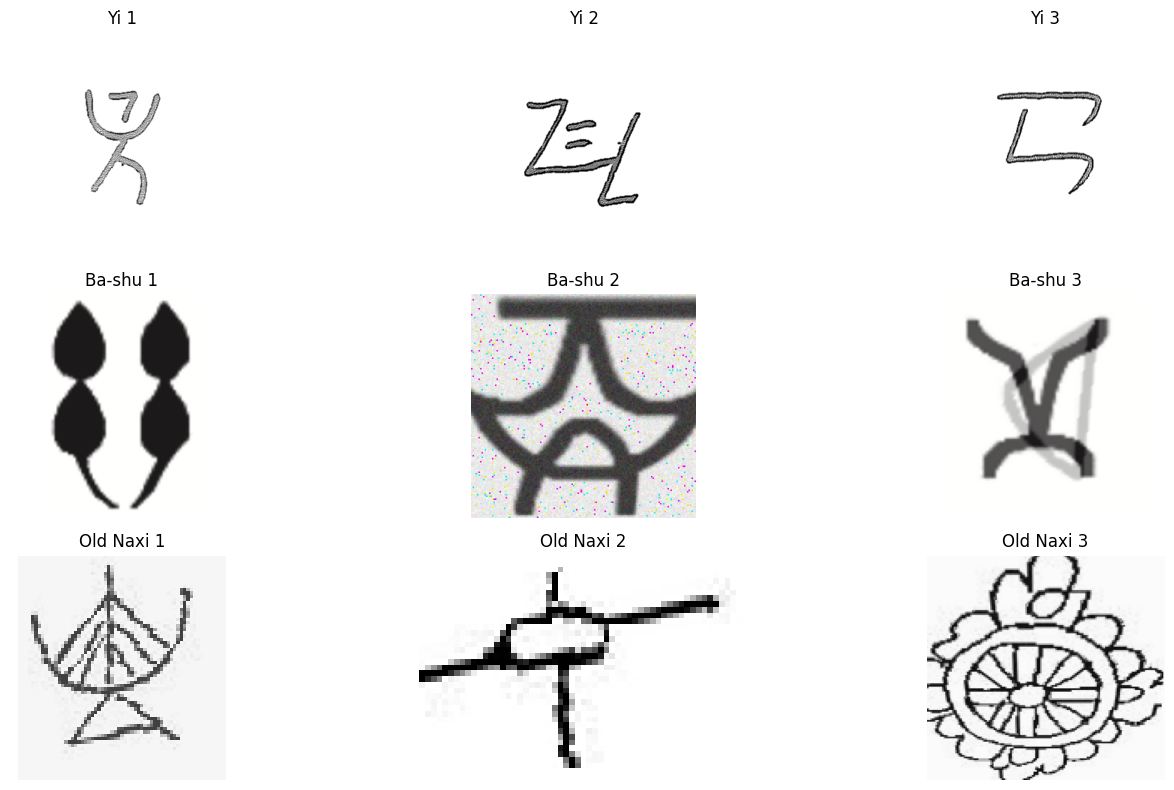

In [ ]:
import random

def process_all_datasets():
    """Process all datasets and create the combined TYC dataset"""
    print("Processing Yi dataset...")
    yi_count = process_yi_dataset()

    print("\nProcessing Old Naxi dataset...")
    old_naxi_count = process_old_naxi_dataset()

    print("\nProcessing Ba-shu dataset...")
    ba_shu_count = process_ba_shu_dataset(yi_count)

    # Get final counts
    final_yi_count = len(load_image_paths(os.path.join(TYC_PATH, 'yi')))
    final_ba_shu_count = len(load_image_paths(os.path.join(TYC_PATH, 'ba-shu')))
    final_old_naxi_count = len(load_image_paths(os.path.join(TYC_PATH, 'old_naxi')))

    print("\n=== TYC Dataset Summary ===")
    print(f"Yi: {final_yi_count} images")
    print(f"Ba-shu: {final_ba_shu_count} images")
    print(f"Old Naxi: {final_old_naxi_count} images")
    print(f"Total: {final_yi_count + final_ba_shu_count + final_old_naxi_count} images")
    print(f"Dataset saved to: {TYC_PATH}")

    # Show sample images from each dataset
    show_samples()

def show_samples():
    """Show sample images from each processed dataset"""
    plt.figure(figsize=(15, 8))

    # Show Yi samples
    yi_files = load_image_paths(os.path.join(TYC_PATH, 'yi'))
    if yi_files:
        for i, path in enumerate(random.sample(yi_files, min(3, len(yi_files)))):
            img = Image.open(path).convert('RGB')
            plt.subplot(3, 3, i+1)
            plt.imshow(img)
            plt.title(f"Yi {i+1}")
            plt.axis('off')

    # Show Ba-shu samples
    ba_shu_files = load_image_paths(os.path.join(TYC_PATH, 'ba-shu'))
    if ba_shu_files:
        for i, path in enumerate(random.sample(ba_shu_files, min(3, len(ba_shu_files)))):
            img = Image.open(path).convert('RGB')
            plt.subplot(3, 3, i+4)
            plt.imshow(img)
            plt.title(f"Ba-shu {i+1}")
            plt.axis('off')

    # Show Old Naxi samples
    old_naxi_files = load_image_paths(os.path.join(TYC_PATH, 'old_naxi'))
    if old_naxi_files:
        for i, path in enumerate(random.sample(old_naxi_files, min(3, len(old_naxi_files)))):
            img = Image.open(path).convert('RGB')
            plt.subplot(3, 3, i+7)
            plt.imshow(img)
            plt.title(f"Old Naxi {i+1}")
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Run the main processing function
process_all_datasets()

# **3. Dataset Loading, Preprocessing, and Augmentation**

## 3.1. Loading and Preprocessing Pipeline

Implementation of a comprehensive image processing pipeline for ancient script analysis.


---


**Dataset Organization**
- **Structure**: Five script datasets with standardized paths
  - Indus, Proto-Cuneiform, Proto-Elamite, Naxi Dongba, Old Naxi, TYC (Sanxingdui + Classical Yi + Old Naxi)
- **Custom PyTorch Dataset**: ScriptDataset class with script-type-aware processing


---


**Preprocessing Pipeline**
- **Selective Denoising**: Script-specific noise reduction
  - Adaptive thresholding for uneven lighting
  - Morphological operations for artifact removal
  - Non-local means denoising for edge preservation
- **Aspect Ratio Preservation**:
  - Custom SquarePad transformer for white-background padding
  - Maintains glyph proportions without distortion
- **Normalization**: ImageNet-standard statistics (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


---


**Error Handling**
- **Robust Image Loading**: Exception handling with placeholder generation
- **Verification System**: Script-specific dataset checks with visualization
- **Format Compatibility**: Support for multiple image formats (.jpg, .png, .bmp, etc.)


---



**Dataset Integration**
- **Combined DataLoader**: Unified loader with script-type labeling
- **Hardware Optimization**: Memory pinning and worker configuration for GPU acceleration
- **Visual Verification**: Preprocessing step visualization for quality assurance

Indus dataset: 391 images found
Visualizing preprocessing for a sample from Indus


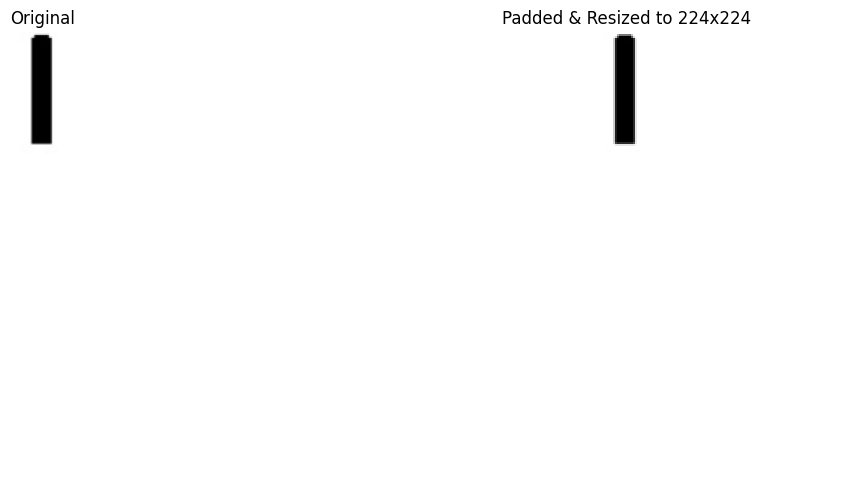

Successfully loaded a batch: shape=torch.Size([1, 3, 224, 224])
Proto-Cuneiform dataset: 2089 images found
Visualizing preprocessing for a sample from Proto-Cuneiform


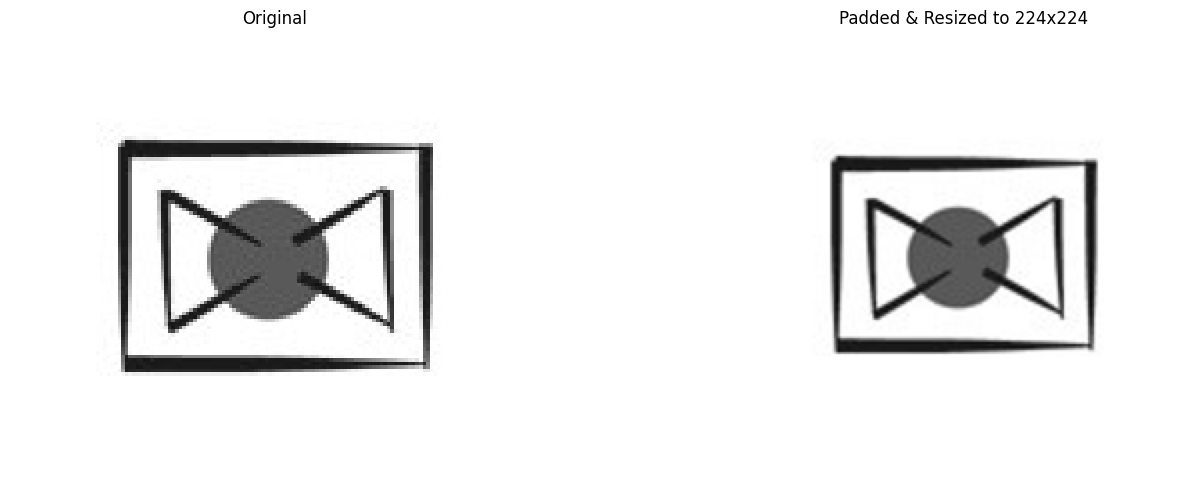

Successfully loaded a batch: shape=torch.Size([1, 3, 224, 224])
Proto-Elamite dataset: 1510 images found
Visualizing preprocessing for a sample from Proto-Elamite


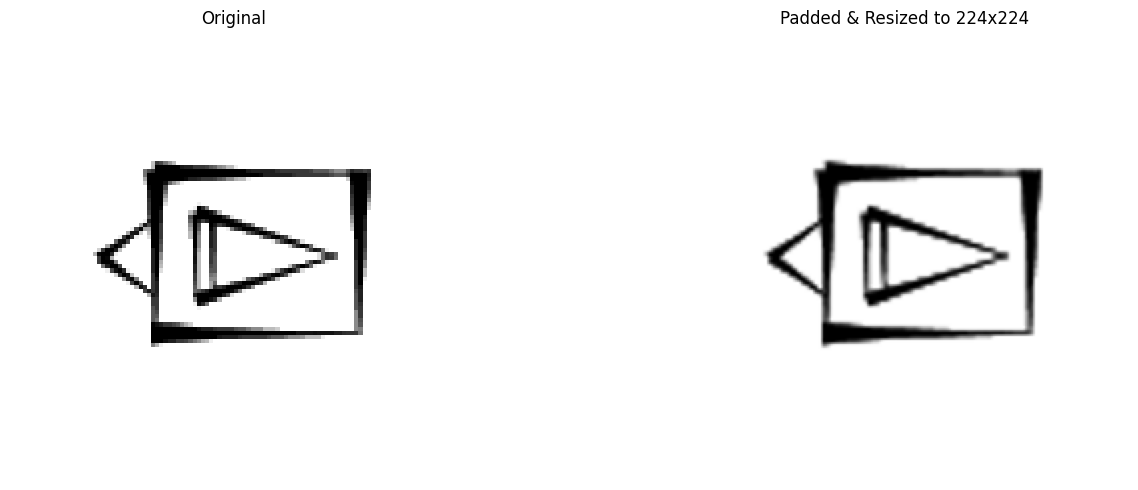

Successfully loaded a batch: shape=torch.Size([1, 3, 224, 224])
Naxi Dongba dataset: 2122 images found
Visualizing preprocessing for a sample from Naxi Dongba


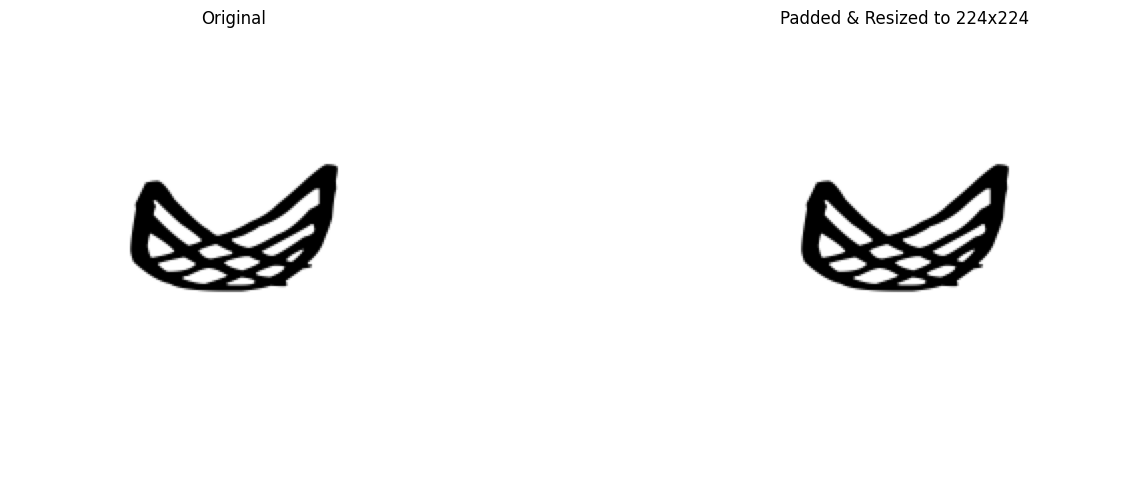

Successfully loaded a batch: shape=torch.Size([1, 3, 224, 224])
Old Naxi dataset: 253 images found
Visualizing preprocessing for a sample from Old Naxi


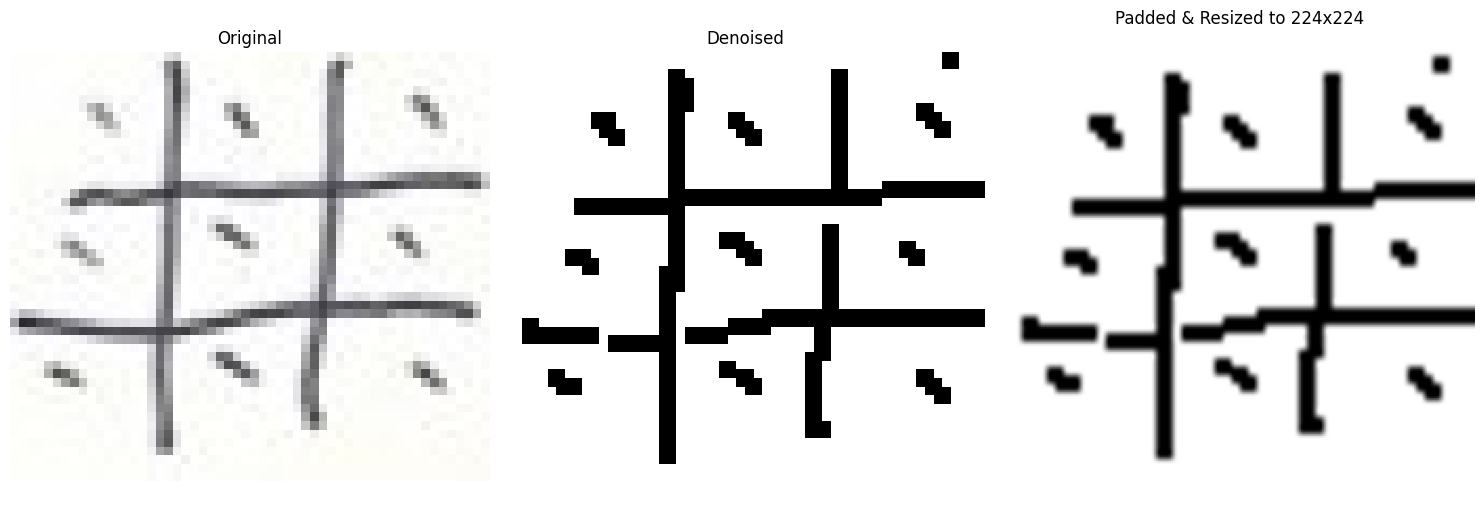

Successfully loaded a batch: shape=torch.Size([1, 3, 224, 224])

Checking entire TYC Dataset:
Visualizing a sample from TYC/yi


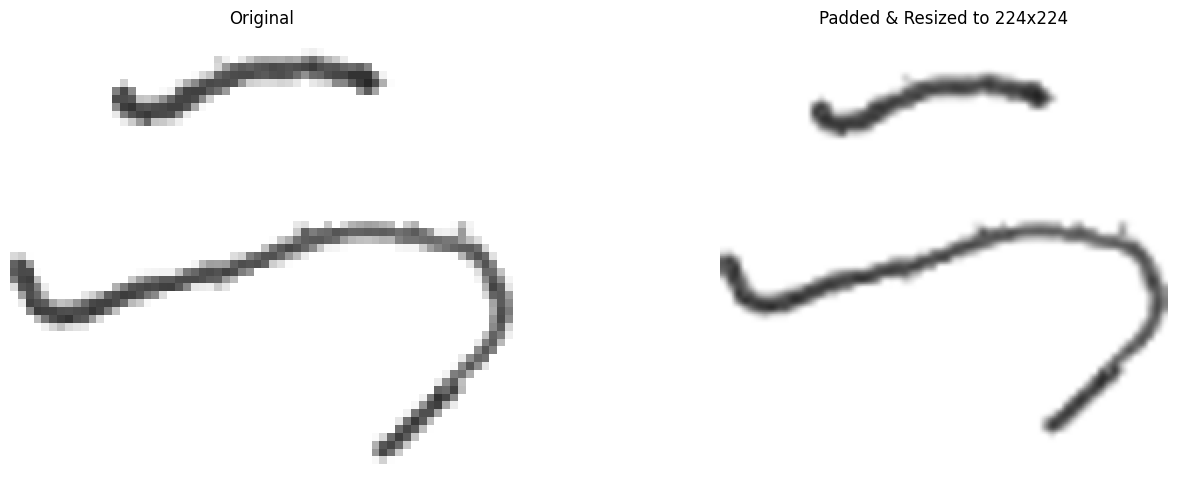

TYC dataset: 8766 total images found
Creating combined dataloader with selective denoising (only old Naxi)...
Added 391 Indus images
Added 2089 Proto-Cuneiform images
Added 1510 Proto-Elamite images
Added 2122 Naxi Dongba images
Added 8766 Tibetan-Yi Corridor images
Combined dataloader created with 14878 total images


In [ ]:
import torchvision.transforms as T

# Set up paths to your datasets
INDUS_PATH = '/content/drive/MyDrive/script_analysis/indus/'
PROTO_CUNEIFORM_PATH = '/content/drive/MyDrive/script_analysis/proto_cuneiform/'
PROTO_ELAMITE_PATH = '/content/drive/MyDrive/script_analysis/proto_elamite/'
NAXI_DONGBA_PATH = '/content/drive/MyDrive/script_analysis/naxi_dongba/'
OLD_NAXI_PATH = '/content/drive/MyDrive/script_analysis/old_naxi/'
TYC_PATH = '/content/drive/MyDrive/script_analysis/tyc/'

class ScriptDataset(Dataset):
    def __init__(self, image_paths, transform=None, script_type=None, denoise_types=None):
        self.image_paths = image_paths
        self.transform = transform
        self.script_type = script_type
        # Set which script types should be denoised
        self.denoise_types = denoise_types or []

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]

        try:
            # Load image and convert to RGB
            image = Image.open(image_path).convert('RGB')

            # Apply denoising if this script type is in the denoise_types list
            if self.script_type in self.denoise_types:
                image = denoise_image(image)

            # Apply preprocessing
            if self.transform:
                image = self.transform(image)

            # Return image and script type (if provided)
            if self.script_type is not None:
                return image, self.script_type
            return image

        except Exception as e:
            print(f"Error loading {image_path}: {e}")
            # Return a placeholder in case of error
            if self.transform:
                placeholder = torch.zeros((3, 224, 224))
                if self.script_type is not None:
                    return placeholder, self.script_type
                return placeholder
            else:
                placeholder = Image.new('RGB', (224, 224), color='white')
                if self.script_type is not None:
                    return placeholder, self.script_type
                return placeholder

def denoise_image(image):
    """
    Apply denoising to the image.
    This function combines multiple methods to handle different types of noise.
    """
    # Convert PIL to numpy for OpenCV operations
    np_image = np.array(image)

    # Convert to grayscale if it's a color image (for processing)
    is_color = len(np_image.shape) == 3 and np_image.shape[2] == 3
    if is_color:
        gray = cv2.cvtColor(np_image, cv2.COLOR_RGB2GRAY)
    else:
        gray = np_image.copy()

    # Apply adaptive thresholding to handle uneven lighting (for binary glyph images)
    # This works well for scripts carved or written on varied surfaces
    binary = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY, 11, 2
    )

    # Apply morphological operations to remove small noise
    kernel = np.ones((2, 2), np.uint8)
    morphed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

    # Apply non-local means denoising (better preserves edges than Gaussian)
    denoised = cv2.fastNlMeansDenoising(morphed, None, 10, 7, 21)

    # Convert back to original format
    if is_color:
        # Create a 3-channel image from the denoised grayscale
        result = np.stack([denoised] * 3, axis=2)
    else:
        result = denoised

    return Image.fromarray(result)

def pad_to_square(image, background_color='white'):
    """
    Custom function to pad an image to square without distortion.
    Uses white background (or specified color) instead of black.
    """
    # Convert PIL to numpy if needed
    if isinstance(image, Image.Image):
        np_image = np.array(image)
    else:
        np_image = image

    height, width = np_image.shape[:2]

    # Determine the size of the square (max of height and width)
    size = max(height, width)

    # Create a square canvas with white background
    if len(np_image.shape) == 3:  # Color image
        if background_color == 'white':
            square = np.ones((size, size, 3), dtype=np.uint8) * 255
        else:
            square = np.zeros((size, size, 3), dtype=np.uint8)
    else:  # Grayscale
        if background_color == 'white':
            square = np.ones((size, size), dtype=np.uint8) * 255
        else:
            square = np.zeros((size, size), dtype=np.uint8)

    # Calculate padding to center the image
    pad_height = (size - height) // 2
    pad_width = (size - width) // 2

    # Place the original image in the center of the square
    if len(np_image.shape) == 3:  # Color image
        square[pad_height:pad_height+height, pad_width:pad_width+width, :] = np_image
    else:  # Grayscale
        square[pad_height:pad_height+height, pad_width:pad_width+width] = np_image

    # Convert back to PIL if input was PIL
    if isinstance(image, Image.Image):
        return Image.fromarray(square)
    return square

class SquarePad:
    """
    Custom transform to pad images to square while preserving aspect ratio.
    """
    def __init__(self, background_color='white'):
        self.background_color = background_color

    def __call__(self, image):
        return pad_to_square(image, self.background_color)

def get_train_transforms(img_size=224, background_color='white'):
    """
    Returns transforms for training images optimized for Swin Transformer.
    No augmentation as requested.
    """
    return T.Compose([
        SquarePad(background_color),  # Pad to square first
        T.Resize(img_size),  # Then resize
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

def get_test_transforms(img_size=224, background_color='white'):
    """
    Returns transforms for validation/test images optimized for Swin Transformer.
    """
    return T.Compose([
        SquarePad(background_color),  # Pad to square first
        T.Resize(img_size),  # Then resize
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

# Function to load image paths from a directory
def load_image_paths(directory):
    """
    Loads all valid image paths from a directory recursively.
    """
    image_paths = []
    valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff']

    if not os.path.exists(directory):
        print(f"Warning: Directory {directory} does not exist!")
        return image_paths

    for root, _, files in os.walk(directory):
        for file in files:
            if any(file.lower().endswith(ext) for ext in valid_extensions):
                image_paths.append(os.path.join(root, file))

    return image_paths

# Create datasets and dataloaders
def create_dataloader(directory, transform, batch_size=32, script_type=None, shuffle=True, denoise_types=None):
    """
    Creates a DataLoader for a given directory of images.

    Args:
        directory: Path to image directory
        transform: Transforms to apply to images
        batch_size: Batch size for DataLoader
        script_type: Label for the script type
        shuffle: Whether to shuffle the data
        denoise_types: List of script types to apply denoising to
    """
    image_paths = load_image_paths(directory)

    if len(image_paths) == 0:
        print(f"Warning: No images found in {directory}")

    dataset = ScriptDataset(image_paths, transform, script_type, denoise_types=denoise_types)

    # Use fewer workers for Colab compatibility
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=2,  # Adjusted for Colab
        pin_memory=True
    )

def visualize_preprocessing(image_path, img_size=224, apply_denoise=False):
    """
    Visualizes the steps of preprocessing to verify the glyph is properly handled.
    """
    # Load original image
    original = Image.open(image_path).convert('RGB')

    # Apply denoising if enabled
    if apply_denoise:
        denoised = denoise_image(original)
        # Apply square padding
        padded = pad_to_square(denoised, 'white')
    else:
        # Apply square padding
        padded = pad_to_square(original, 'white')

    # Resize
    resized = padded.resize((img_size, img_size))

    # Display all steps
    fig, axes = plt.subplots(1, 3 if apply_denoise else 2, figsize=(15, 5))

    axes[0].imshow(original)
    axes[0].set_title("Original")
    axes[0].axis('off')

    if apply_denoise:
        axes[1].imshow(denoised, cmap='gray')
        axes[1].set_title("Denoised")
        axes[1].axis('off')

        axes[2].imshow(resized)
        axes[2].set_title(f"Padded & Resized to {img_size}x{img_size}")
        axes[2].axis('off')
    else:
        axes[1].imshow(resized)
        axes[1].set_title(f"Padded & Resized to {img_size}x{img_size}")
        axes[1].axis('off')

    plt.tight_layout()
    plt.show()

# Verify that we can load the datasets and check preprocessing
def check_dataset(path, dataset_name, apply_denoise=False):
    """
    Checks that a dataset can be loaded and visualizes a sample with preprocessing.
    """
    paths = load_image_paths(path)
    print(f"{dataset_name} dataset: {len(paths)} images found")

    if len(paths) > 0:
        # Display original and preprocessed images
        print(f"Visualizing preprocessing for a sample from {dataset_name}")
        visualize_preprocessing(paths[0], apply_denoise=apply_denoise)

        # Test with DataLoader to verify everything works end-to-end
        transform = get_test_transforms(background_color='white')

        # Only apply denoising to specified scripts
        denoise_types = ["Old Naxi"] if apply_denoise else []

        loader = create_dataloader(
            path,
            transform,
            batch_size=1,
            script_type=dataset_name,
            denoise_types=denoise_types
        )

        # Load one batch
        try:
            sample, label = next(iter(loader))
            print(f"Successfully loaded a batch: shape={sample.shape}")
        except Exception as e:
            print(f"Error loading batch: {e}")
    else:
        print(f"No images found in {path}")

# Update the combined dataloader to handle TYC as a single dataset
def create_combined_dataloader(batch_size=32, img_size=224, shuffle=True):
    """
    Creates a combined dataloader for all script types.
    Treats TYC as a single unified dataset of "Tibetan-Yi Corridor Scripts".
    No additional denoising is applied during loading.
    """
    transform = get_train_transforms(img_size=img_size)

    # We don't need to apply denoising to Old Naxi at loading time
    # since it was already denoised during TYC dataset creation
    denoise_types = []  # Empty list means no denoising during loading

    datasets = []

    # Add Indus, Proto-Cuneiform, Proto-Elamite, Naxi Dongba datasets
    if os.path.exists(INDUS_PATH):
        indus_paths = load_image_paths(INDUS_PATH)
        if indus_paths:
            datasets.append(ScriptDataset(indus_paths, transform, "Indus", denoise_types))
            print(f"Added {len(indus_paths)} Indus images")

    if os.path.exists(PROTO_CUNEIFORM_PATH):
        cuneiform_paths = load_image_paths(PROTO_CUNEIFORM_PATH)
        if cuneiform_paths:
            datasets.append(ScriptDataset(cuneiform_paths, transform, "Proto-Cuneiform", denoise_types))
            print(f"Added {len(cuneiform_paths)} Proto-Cuneiform images")

    if os.path.exists(PROTO_ELAMITE_PATH):
        elamite_paths = load_image_paths(PROTO_ELAMITE_PATH)
        if elamite_paths:
            datasets.append(ScriptDataset(elamite_paths, transform, "Proto-Elamite", denoise_types))
            print(f"Added {len(elamite_paths)} Proto-Elamite images")

    if os.path.exists(NAXI_DONGBA_PATH):
        dongba_paths = load_image_paths(NAXI_DONGBA_PATH)
        if dongba_paths:
            datasets.append(ScriptDataset(dongba_paths, transform, "Naxi Dongba", denoise_types))
            print(f"Added {len(dongba_paths)} Naxi Dongba images")

    # For TYC, we'll gather all files from all subfolders and treat them as one dataset
    if os.path.exists(TYC_PATH):
        tyc_paths = []
        # Collect images from all TYC subfolders
        for subfolder in ['yi', 'ba-shu', 'old_naxi']:
            subfolder_path = os.path.join(TYC_PATH, subfolder)
            if os.path.exists(subfolder_path):
                subfolder_paths = load_image_paths(subfolder_path)
                tyc_paths.extend(subfolder_paths)

        if tyc_paths:
            datasets.append(ScriptDataset(tyc_paths, transform, "Tibetan-Yi Corridor", denoise_types))
            print(f"Added {len(tyc_paths)} Tibetan-Yi Corridor images")

    # Combine all datasets
    combined_dataset = torch.utils.data.ConcatDataset(datasets)

    return DataLoader(
        combined_dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=2,
        pin_memory=True
    )

# Update check_datasets function to check TYC as a single dataset
def check_all_datasets():
    # Check the regular datasets
    check_dataset(INDUS_PATH, "Indus", apply_denoise=False)
    check_dataset(PROTO_CUNEIFORM_PATH, "Proto-Cuneiform", apply_denoise=False)
    check_dataset(PROTO_ELAMITE_PATH, "Proto-Elamite", apply_denoise=False)
    check_dataset(NAXI_DONGBA_PATH, "Naxi Dongba", apply_denoise=False)
    check_dataset(OLD_NAXI_PATH, "Old Naxi", apply_denoise=True) # Only OLD_NAXI gets denoised

    # Check TYC as a single dataset (no denoising needed as it was done during creation)
    print("\nChecking entire TYC Dataset:")

    # Get a random sample from one of the TYC subfolders for visualization
    for subfolder in ['yi', 'ba-shu', 'old_naxi']:
        subfolder_path = os.path.join(TYC_PATH, subfolder)
        if os.path.exists(subfolder_path):
            paths = load_image_paths(subfolder_path)
            if paths:
                print(f"Visualizing a sample from TYC/{subfolder}")
                visualize_preprocessing(paths[0], apply_denoise=False)
                break

    # Count total TYC images
    tyc_paths = []
    for subfolder in ['yi', 'ba-shu', 'old_naxi']:
        subfolder_path = os.path.join(TYC_PATH, subfolder)
        if os.path.exists(subfolder_path):
            subfolder_paths = load_image_paths(subfolder_path)
            tyc_paths.extend(subfolder_paths)

    print(f"TYC dataset: {len(tyc_paths)} total images found")

# Run the dataset checker
check_all_datasets()

# Example: Create a combined dataloader with selective denoising
print("Creating combined dataloader with selective denoising (only old Naxi)...")
combined_loader = create_combined_dataloader(batch_size=16)
print(f"Combined dataloader created with {len(combined_loader.dataset)} total images")

## 3.2 Custom Augmentation Pipeline

Implementation of a specialized augmentation framework for ancient script preservation and enhancement.


---


**Data Augmentation Strategy**
- **Structure-Preserving Transformations**:
  - White-background rotation maintaining glyph integrity
  - Controlled elastic deformations simulating material warping (clay/stone)
  - Speckle noise patterns modeling historical degradation
  - Background texturing simulating ancient writing surfaces


---


**Technical Implementation**
- **Multi-Tier Augmentation**:
  - 8 distinct augmentation combinations with tailored intensity
  - 4 augmentations generated per original image
  - Script-specific application (Indus, Proto-Cuneiform, Proto-Elamite)
  - Selective application based on script characteristics


---


**Augmentation Parameters**
- **Geometric**: Rotation ±45°, scaling 0.85-1.15x, controlled affine transformations
- **Appearance**: Brightness/contrast variation 0.7-1.5x, adaptive noise 1-5%
- **Material Simulation**: Elastic transforms (α=40, σ=4), texture patterns


---


**Dataset Integration**
- **Augmented Dataset Scale**: 5x expansion for selected scripts
- **On-Demand Generation**: Dynamic augmentation during training
- **Combined DataLoader**: Integration of augmented and standard datasets
- **Visual Verification**: Augmentation comparison framework with denormalization




---



This pipeline creates archeologically plausible variations that enhance model robustness while preserving diagnostic script features.

Creating in-memory augmented datasets...
Created dataset for Indus: 391 original images + 1564 augmentations
Created dataset for Proto-Cuneiform: 2089 original images + 8356 augmentations
Created dataset for Proto-Elamite: 1510 original images + 6040 augmentations

Augmented dataset statistics:
- Total images: 22325
- Batch size: 32
- Batches per epoch: 698

Visualizing Indus script augmentations:


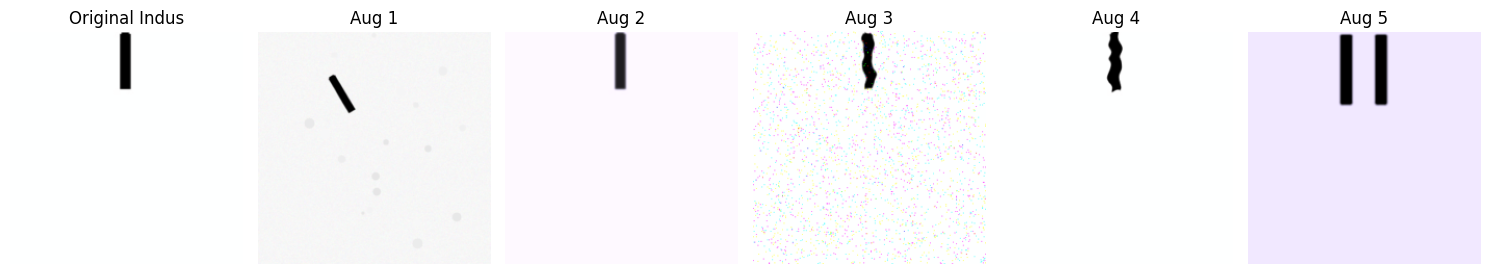


Visualizing Proto-Cuneiform augmentations:


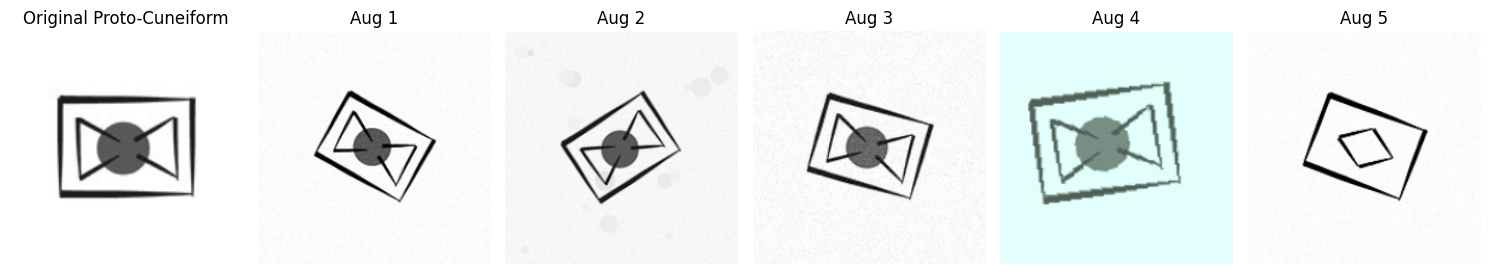


Visualizing Proto-Elamite augmentations:


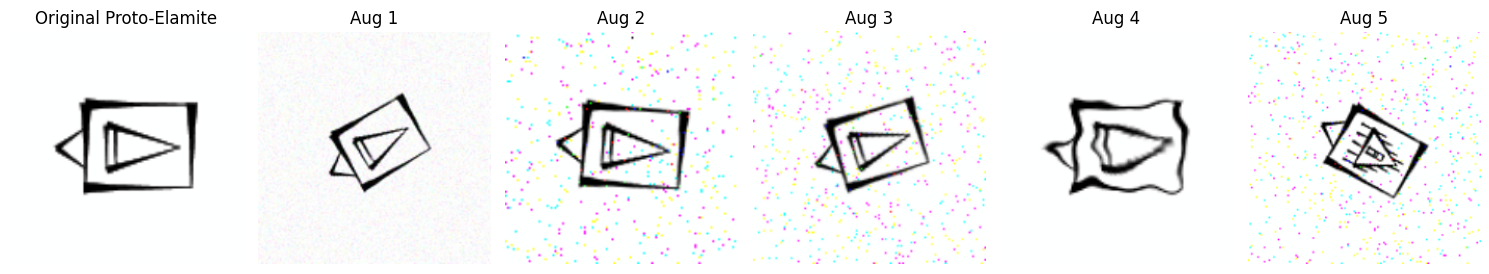

In [ ]:
class AugmentationPipeline:
    """Class for generating more intense augmentations while preserving glyph structure"""

    def __init__(self):
        # Define ranges for augmentation parameters - more intense
        self.rotation_range = (-45, 45)  # More rotation but not 180°
        self.brightness_range = (0.7, 1.5)  # More extreme brightness
        self.contrast_range = (0.7, 1.5)  # More extreme contrast
        self.sharpness_range = (0.7, 1.6)  # More extreme sharpness
        self.noise_range = (0.01, 0.05)  # Increased noise range
        self.blur_range = (0.5, 1.2)  # Increased blur range
        self.scale_range = (0.85, 1.15)  # Scale variation

    def rotate(self, image):
        """Apply rotation with white background - more extreme rotation"""
        angle = random.uniform(*self.rotation_range)

        # Convert to RGBA to handle transparency during rotation
        rgba = image.convert('RGBA')

        # Rotate with expand=True to avoid cropping
        rotated = rgba.rotate(angle, resample=Image.BICUBIC, expand=True)

        # Create a new white background image of the same size
        white_bg = Image.new('RGBA', rotated.size, (255, 255, 255, 255))

        # Paste rotated image onto white background using alpha compositing
        result = Image.alpha_composite(white_bg, rotated)

        # Convert back to RGB
        return result.convert('RGB')

    def adjust_brightness(self, image):
        """Adjust brightness with more extreme range"""
        factor = random.uniform(*self.brightness_range)
        enhancer = ImageEnhance.Brightness(image)
        return enhancer.enhance(factor)

    def adjust_contrast(self, image):
        """Adjust contrast with more extreme range"""
        factor = random.uniform(*self.contrast_range)
        enhancer = ImageEnhance.Contrast(image)
        return enhancer.enhance(factor)

    def adjust_sharpness(self, image):
        """Adjust sharpness with more extreme range"""
        factor = random.uniform(*self.sharpness_range)
        enhancer = ImageEnhance.Sharpness(image)
        return enhancer.enhance(factor)

    def add_noise(self, image):
        """Add more noticeable noise"""
        noise_factor = random.uniform(*self.noise_range)
        img_array = np.array(image).astype(np.float32)
        noise = np.random.normal(0, noise_factor * 255, img_array.shape)
        noisy_img = np.clip(img_array + noise, 0, 255).astype(np.uint8)
        return Image.fromarray(noisy_img)

    def add_speckle_noise(self, image):
        """Add speckle noise that simulates degradation"""
        img_array = np.array(image)
        row, col, ch = img_array.shape

        # Generate random black and white dots
        speckle = np.random.rand(row, col, ch)
        speckle = (speckle > 0.99) * 255  # 1% of pixels become white dots

        # Generate random black dots
        black_speckle = np.random.rand(row, col, ch)
        black_speckle = (black_speckle > 0.99) * -255  # 1% of pixels become black dots

        # Add both to image
        noisy = img_array + speckle + black_speckle
        return Image.fromarray(np.clip(noisy, 0, 255).astype(np.uint8))

    def blur(self, image):
        """Apply blur with varying intensity"""
        radius = random.uniform(*self.blur_range)
        return image.filter(ImageFilter.GaussianBlur(radius=radius))

    def color_jitter(self, image):
        """Add slight color variation while preserving structure"""
        # Split into channels
        r, g, b = image.split()

        # Apply slight channel-specific adjustments
        channels = []
        for ch in [r, g, b]:
            enhancer = ImageEnhance.Brightness(ch)
            # Vary brightness per channel to create color shifts
            factor = random.uniform(0.9, 1.1)
            channels.append(enhancer.enhance(factor))

        # Combine channels back
        return Image.merge("RGB", channels)

    def add_background_texture(self, image):
        """Add subtle texture to the background"""
        # Create a texture pattern
        texture_size = image.size
        texture = np.zeros(texture_size + (3,), dtype=np.uint8)

        # Generate texture pattern (e.g., noise pattern)
        for ch in range(3):
            texture[:, :, ch] = np.random.randint(240, 255, texture_size)

        # Add some texture patterns
        for _ in range(20):  # Add some random shapes
            x, y = np.random.randint(0, texture_size[0]), np.random.randint(0, texture_size[1])
            radius = np.random.randint(3, 10)
            color = np.random.randint(230, 250)
            cv2.circle(texture, (x, y), radius, (color, color, color), -1)

        # Convert image to numpy array
        img_array = np.array(image)

        # Create mask where original image pixels are not white
        # This preserves the glyph structure
        mask = np.all(img_array > 240, axis=2)

        # Replace white background with texture
        for ch in range(3):
            img_array[:, :, ch][mask] = texture[:, :, ch][mask]

        return Image.fromarray(img_array)

    def slight_affine(self, image):
        """Apply a slight affine transformation with fixed TF.affine call"""
        # Get a small random affine transformation
        angle = random.uniform(-10, 10)
        scale = random.uniform(*self.scale_range)

        # Apply transformation
        width, height = image.size

        # Calculate translation in pixels
        translate_x = int(random.uniform(-0.1, 0.1) * width)
        translate_y = int(random.uniform(-0.1, 0.1) * height)

        # Apply affine transform using torchvision functional
        # Using fill parameter instead of fillcolor (compatibility fix)
        return TF.affine(
            image,
            angle=angle,
            translate=[translate_x, translate_y],
            scale=scale,
            shear=random.uniform(-5, 5),  # Small shear for distortion
            fill=255  # White background (255 for all channels)
        )

    def elastic_transform(self, image, alpha=40, sigma=4):
        """Apply elastic deformation to simulate material warping"""
        img_array = np.array(image)
        shape = img_array.shape[:2]

        # Random displacement fields
        dx = np.random.rand(*shape) * 2 - 1
        dy = np.random.rand(*shape) * 2 - 1

        # Apply Gaussian filter
        dx = cv2.GaussianBlur(dx, (0, 0), sigma) * alpha
        dy = cv2.GaussianBlur(dy, (0, 0), sigma) * alpha

        # Create mesh grid
        x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))

        # Displacement with bounds checking
        indices_x = np.clip(x + dx, 0, shape[1]-1).astype(np.float32)
        indices_y = np.clip(y + dy, 0, shape[0]-1).astype(np.float32)

        # Apply elastic transform
        distorted = cv2.remap(img_array, indices_x, indices_y,
                             interpolation=cv2.INTER_LINEAR,
                             borderMode=cv2.BORDER_CONSTANT,
                             borderValue=(255, 255, 255))

        return Image.fromarray(distorted)

    def generate_augmentations(self, image, num_variations=4):
        """Generate multiple augmentations for a single image"""
        augmented_images = []

        # Define different augmentation combinations - more intense
        augmentation_types = [
            # Combination 1: Rotation + brightness + noise
            lambda img: self.add_noise(self.adjust_brightness(self.rotate(img))),

            # Combination 2: Contrast + affine + color jitter
            lambda img: self.color_jitter(self.adjust_contrast(self.slight_affine(img))),

            # Combination 3: Speckle noise + sharpness + rotation
            lambda img: self.adjust_sharpness(self.add_speckle_noise(self.rotate(img))),

            # Combination 4: Elastic transform + contrast
            lambda img: self.adjust_contrast(self.elastic_transform(img)),

            # Combination 5: Background texture + rotation
            lambda img: self.add_background_texture(self.rotate(img)),

            # Combination 6: Intense multiple adjustments
            lambda img: self.add_noise(self.adjust_contrast(
                       self.adjust_brightness(self.rotate(img)))),

            # Combination 7: Blur + contrast + color
            lambda img: self.color_jitter(self.adjust_contrast(self.blur(img))),

            # Combination 8: Elastic + speckle noise
            lambda img: self.add_speckle_noise(self.elastic_transform(img))
        ]

        # Select random augmentations
        selected_augmentations = random.sample(augmentation_types, min(num_variations, len(augmentation_types)))

        # Apply selected augmentations
        for augment_func in selected_augmentations:
            try:
                aug_img = augment_func(image)
                augmented_images.append(aug_img)
            except Exception as e:
                print(f"Augmentation error: {e}")
                # Add original as fallback
                augmented_images.append(image)

            if len(augmented_images) >= num_variations:
                break

        # If we still need more variations, add some basic ones
        while len(augmented_images) < num_variations:
            try:
                # Simple rotation as fallback
                aug_img = self.rotate(image)
                augmented_images.append(aug_img)
            except Exception as e:
                print(f"Fallback augmentation error: {e}")
                augmented_images.append(image)

        return augmented_images

class AugmentedScriptDataset(Dataset):
    """Dataset class that generates augmentations on-the-fly"""

    def __init__(self, image_paths, transform=None, script_type=None,
                 denoise_types=None, augmentations_per_image=4):
        self.original_paths = image_paths
        self.transform = transform
        self.script_type = script_type
        self.denoise_types = denoise_types or []
        self.augmentations_per_image = augmentations_per_image
        self.augmenter = AugmentationPipeline()

        # Calculate total length (original images + augmented images)
        self.total_len = len(self.original_paths) * (1 + augmentations_per_image)

        print(f"Created dataset for {script_type}: {len(self.original_paths)} original images + "
              f"{len(self.original_paths) * augmentations_per_image} augmentations")

    def __len__(self):
        return self.total_len

    def __getitem__(self, idx):
        # Determine if this is an original or augmented image
        original_count = len(self.original_paths)

        if idx < original_count:
            # Return original image
            image_path = self.original_paths[idx]
            try:
                image = Image.open(image_path).convert('RGB')

                # Apply denoising if needed
                if self.script_type in self.denoise_types:
                    image = denoise_image(image)

                # Apply padding to square
                image = pad_to_square(image, 'white')

                # Apply transform
                if self.transform:
                    image = self.transform(image)

                # Return image and script type
                if self.script_type is not None:
                    return image, self.script_type
                return image

            except Exception as e:
                print(f"Error loading {image_path}: {e}")
                placeholder = torch.zeros((3, 224, 224))
                if self.script_type is not None:
                    return placeholder, self.script_type
                return placeholder
        else:
            # Return augmented image
            # Calculate which original image to augment and which variation to use
            original_idx = (idx - original_count) // self.augmentations_per_image
            aug_variation = (idx - original_count) % self.augmentations_per_image

            # Get the original image path
            if original_idx < len(self.original_paths):
                original_path = self.original_paths[original_idx]
            else:
                # Fallback if index out of range
                original_path = self.original_paths[0]

            try:
                # Load original image
                original = Image.open(original_path).convert('RGB')

                # Apply denoising if needed
                if self.script_type in self.denoise_types:
                    original = denoise_image(original)

                # Apply padding to square first
                original = pad_to_square(original, 'white')

                # Generate augmentations for this image
                augmented_images = self.augmenter.generate_augmentations(
                    original, self.augmentations_per_image)

                # Select the specific augmentation variation
                if aug_variation < len(augmented_images):
                    aug_image = augmented_images[aug_variation]
                else:
                    # Fallback if not enough variations were generated
                    aug_image = original

                # Apply transform
                if self.transform:
                    aug_image = self.transform(aug_image)

                # Return augmented image and script type
                if self.script_type is not None:
                    return aug_image, self.script_type
                return aug_image

            except Exception as e:
                print(f"Error processing augmentation for {original_path}: {e}")
                placeholder = torch.zeros((3, 224, 224))
                if self.script_type is not None:
                    return placeholder, self.script_type
                return placeholder

# Create in-memory augmented datasets for the three specified scripts
print("Creating in-memory augmented datasets...")

# Load paths from original datasets
indus_paths = load_image_paths(INDUS_PATH)
cuneiform_paths = load_image_paths(PROTO_CUNEIFORM_PATH)
elamite_paths = load_image_paths(PROTO_ELAMITE_PATH)
dongba_paths = load_image_paths(NAXI_DONGBA_PATH)
old_naxi_paths = load_image_paths(OLD_NAXI_PATH)

# Set transformations
train_transform = get_train_transforms(img_size=224)
test_transform = get_test_transforms(img_size=224)

# Set which script types to denoise (based on original code)
denoise_types = ["Old Naxi"]

# Create augmented datasets with 4 augmentations per original image
indus_dataset = AugmentedScriptDataset(
    indus_paths, train_transform, "Indus", denoise_types, augmentations_per_image=4
)

cuneiform_dataset = AugmentedScriptDataset(
    cuneiform_paths, train_transform, "Proto-Cuneiform", denoise_types, augmentations_per_image=4
)

elamite_dataset = AugmentedScriptDataset(
    elamite_paths, train_transform, "Proto-Elamite", denoise_types, augmentations_per_image=4
)

# Create regular datasets for the others (no augmentation)
dongba_dataset = ScriptDataset(dongba_paths, train_transform, "Naxi Dongba", denoise_types)
old_naxi_dataset = ScriptDataset(old_naxi_paths, train_transform, "Old Naxi", denoise_types)

# Create a combined dataset with all scripts
all_datasets = [
    indus_dataset,
    cuneiform_dataset,
    elamite_dataset,
    dongba_dataset,
    old_naxi_dataset
]

# Remove any empty datasets
all_datasets = [ds for ds in all_datasets if len(ds) > 0]

# Create combined dataset
combined_dataset = ConcatDataset(all_datasets)

# Create dataloaders
batch_size = 32
augmented_train_loader = DataLoader(
    combined_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

# Print statistics
print(f"\nAugmented dataset statistics:")
print(f"- Total images: {len(combined_dataset)}")
print(f"- Batch size: {batch_size}")
print(f"- Batches per epoch: {len(augmented_train_loader)}")

# Visualize a few examples from the augmented dataset
def visualize_augmentations(dataset_idx=0, num_augmentations=5):
    """
    Visualize original image and its augmentations

    Args:
        dataset_idx: Index of the dataset in all_datasets list
        num_augmentations: Number of augmentations to show
    """
    if len(all_datasets) <= dataset_idx:
        print("Dataset index out of range")
        return

    dataset = all_datasets[dataset_idx]
    if not hasattr(dataset, 'augmenter'):
        print("Selected dataset does not support augmentation")
        return

    # Get an original image
    original_idx = 0
    original_img, label = dataset[original_idx]

    # Get corresponding augmentations
    augmented_images = []
    aug_start_idx = len(dataset.original_paths)
    for i in range(num_augmentations):
        aug_idx = aug_start_idx + (original_idx * dataset.augmentations_per_image) + i
        if aug_idx < len(dataset):
            aug_img, _ = dataset[aug_idx]
            augmented_images.append(aug_img)

    # Prepare visualization
    plt.figure(figsize=(15, 5))

    # Display original image
    plt.subplot(1, num_augmentations+1, 1)

    # Convert tensor to image
    if isinstance(original_img, torch.Tensor):
        img = original_img.permute(1, 2, 0).numpy()
        # Denormalize
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        plt.imshow(img)
    else:
        plt.imshow(np.array(original_img))

    plt.title(f"Original {label}")
    plt.axis('off')

    # Display augmentations
    for i, aug_img in enumerate(augmented_images):
        plt.subplot(1, num_augmentations+1, i+2)

        # Convert tensor to image
        if isinstance(aug_img, torch.Tensor):
            img = aug_img.permute(1, 2, 0).numpy()
            # Denormalize
            img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            img = np.clip(img, 0, 1)
            plt.imshow(img)
        else:
            plt.imshow(np.array(aug_img))

        plt.title(f"Aug {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Show augmentations for each dataset type
print("\nVisualizing Indus script augmentations:")
visualize_augmentations(dataset_idx=0, num_augmentations=5)

print("\nVisualizing Proto-Cuneiform augmentations:")
visualize_augmentations(dataset_idx=1, num_augmentations=5)

print("\nVisualizing Proto-Elamite augmentations:")
visualize_augmentations(dataset_idx=2, num_augmentations=5)

# Use this dataloader for training
# augmented_train_loader

# **4. Swin Transformer Training for Script Feature Extraction**

## 4.1 Self-Supervised Swin Transformer with Contrastive Learning

Implementation of a vision transformer architecture using hierarchical feature extraction and contrastive loss for script representation learning.


---


**Model Architecture**
- **Backbone**: Swin Transformer base model (patch4_window7_224)
- **Feature Dimension**: 1024-dimensional embeddings from global average pooling
- **Projection Head**: Two-layer MLP with batch normalization (1024→1024→256)
- **Optimization**: Mixed precision training with torch.amp for efficiency
---
**Training Methodology**
- **Loss Function**: NT-Xent contrastive loss (temperature=0.07)
- **Optimizer**: AdamW with weight decay 1e-4
- **Learning Rate**: Cosine schedule with warmup (base lr=2e-4)
- **Regularization**: Gradient clipping at 1.0 norm
- **Early Stopping**: Patience-based monitoring of validation loss
- **Training Strategy**: Script-specific models with paired contrastive examples
---
**Feature Extraction Pipeline**
- **Embedding Generation**: Script-level feature vectors for comparison
- **Similarity Computation**: Cosine similarity between script centroids
- **Visualization**: t-SNE dimensionality reduction for embedding relationships
- **Comparative Analysis**: Cross-script similarity heatmaps
---
**Performance Monitoring**
- **Loss Tracking**: Training and validation loss curves
- **Learning Rate**: Adaptive scheduling visualization
- **Model Persistence**: Checkpoint saving for best validation performance
- **Output**: Trained feature extractors for Indus, Proto-Cuneiform, and Proto-Elamite scripts

In [ ]:
# Import libraries needed for Swin Transformer training
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import timm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
from tqdm.notebook import tqdm
import pandas as pd
from datetime import datetime

# Set random seeds for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Define paths for saving models and results
MODEL_DIR = '/content/drive/MyDrive/script_analysis/models'
os.makedirs(MODEL_DIR, exist_ok=True)
RESULTS_DIR = '/content/drive/MyDrive/script_analysis/results'
os.makedirs(RESULTS_DIR, exist_ok=True)

# Script Feature Extractor model
class ScriptFeatureExtractor(nn.Module):
    """
    Swin Transformer model for script feature extraction with an optional classification head
    """
    def __init__(self, model_name='swin_base_patch4_window7_224', embedding_dim=1024, pretrained=True):
        super(ScriptFeatureExtractor, self).__init__()
        # Load pre-trained Swin Transformer model with global pooling
        self.backbone = timm.create_model(
            model_name,
            pretrained=pretrained,
            num_classes=0,  # Remove classifier head
            global_pool='avg'  # Use global average pooling
        )

        # Store the embedding dimension
        self.embedding_dim = self.backbone.num_features

        # Store model name
        self.model_name = model_name

    def forward(self, x):
        # Extract features only - no classification
        features = self.backbone(x)
        return features

    def extract_features(self, x):
        """Extract feature embeddings (same as forward for this model)"""
        with torch.no_grad():
            return self.forward(x)

# NT-Xent loss function - optimized implementation
def nt_xent_loss(z_i, z_j, temperature=0.07):  # Much lower temperature for sharper contrasts
    batch_size = z_i.size(0)

    # Normalize embeddings to unit norm (important!)
    z_i = F.normalize(z_i, dim=1)
    z_j = F.normalize(z_j, dim=1)

    # Full embedding space for all samples
    representations = torch.cat([z_i, z_j], dim=0)

    # Compute similarity matrix
    similarity_matrix = F.cosine_similarity(representations.unsqueeze(1), representations.unsqueeze(0), dim=2)

    # Create mask for positive pairs
    mask = torch.zeros_like(similarity_matrix)
    mask[range(batch_size), range(batch_size, 2*batch_size)] = 1.
    mask[range(batch_size, 2*batch_size), range(batch_size)] = 1.

    # Compute NT-Xent loss
    similarity_matrix = similarity_matrix / temperature

    # For numerical stability, subtract max along each row
    sim_row_max, _ = torch.max(similarity_matrix, dim=1, keepdim=True)
    similarity_matrix = similarity_matrix - sim_row_max.detach()

    # Compute exp of similarities
    exp_sim = torch.exp(similarity_matrix)

    # Sum over all examples except itself
    mask_no_diag = torch.ones_like(similarity_matrix) - torch.eye(2*batch_size, device=similarity_matrix.device)
    exp_sim_sum = torch.sum(exp_sim * mask_no_diag, dim=1, keepdim=True)

    # Compute log_prob
    log_prob = similarity_matrix - torch.log(exp_sim_sum + 1e-8)

    # Compute mean of log-likelihood over positive pairs
    mean_log_prob = torch.sum(mask * log_prob) / (2 * batch_size)

    # Loss is negative log-likelihood
    return -mean_log_prob

# Function to prepare validation and test loaders for each script type
def prepare_val_test_loaders(script_name, script_paths, val_split=0.2, test_split=0.1):
    """Create validation and test loaders for a script type"""

    # Get test transform
    test_transform = get_test_transforms(img_size=224)

    # Calculate split sizes
    total_size = len(script_paths)
    test_size = int(test_split * total_size)
    val_size = int(val_split * total_size)
    train_size = total_size - val_size - test_size

    # Split paths
    val_paths = script_paths[train_size:train_size+val_size]
    test_paths = script_paths[train_size+val_size:]

    # Create datasets (no augmentation for validation and test)
    denoise_types = ["Old Naxi"]
    val_dataset = ScriptDataset(val_paths, test_transform, script_name, denoise_types)
    test_dataset = ScriptDataset(test_paths, test_transform, script_name, denoise_types)

    # Create dataloaders
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

    return val_loader, test_loader

def train_feature_extractor(
    script_name,
    train_loader,
    val_loader,
    device,
    lr=2e-4,
    epochs=15,
    weight_decay=1e-4,
    patience=4,
    output_dir=MODEL_DIR
):
    """
    Train a feature extraction model for a specific script using contrastive learning

    Args:
        script_name: Name of the script being trained on
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        device: Torch device for training
        lr: Learning rate
        epochs: Number of training epochs
        weight_decay: L2 regularization weight
        patience: Early stopping patience
        output_dir: Directory to save model
    """
    # Import math for scheduler
    import math

    # Set up model
    model = ScriptFeatureExtractor(
        model_name='swin_base_patch4_window7_224',
        pretrained=True
    ).to(device)

    # Feature dimension
    feature_dim = model.embedding_dim

    # Improved projection head with batch normalization
    projection_head = nn.Sequential(
        nn.Linear(feature_dim, feature_dim),
        nn.BatchNorm1d(feature_dim),
        nn.ReLU(),
        nn.Linear(feature_dim, 256),
        nn.BatchNorm1d(256)
    ).to(device)

    # Set up optimizer
    optimizer = optim.AdamW(
        list(model.parameters()) + list(projection_head.parameters()),
        lr=lr,
        weight_decay=weight_decay,
        betas=(0.9, 0.98)
    )

    # Custom scheduler with warmup
    def warmup_cosine_schedule(step, total_steps, warmup=0.1):
        if step < warmup * total_steps:
            return float(step) / float(max(1.0, warmup * total_steps))
        progress = float(step - warmup * total_steps) / float(max(1.0, total_steps - warmup * total_steps))
        return 0.5 * (1.0 + math.cos(math.pi * progress))

    total_steps = epochs * len(train_loader)
    scheduler = torch.optim.lr_scheduler.LambdaLR(
        optimizer,
        lr_lambda=lambda step: warmup_cosine_schedule(step, total_steps)
    )

    scaler = torch.amp.GradScaler('cuda')

    # Initialize tracking variables
    best_val_loss = float('inf')
    best_epoch = 0
    epochs_no_improve = 0
    global_step = 0

    # History for plotting
    history = {
        'train_loss': [],
        'val_loss': [],
        'learning_rates': []
    }

    # Training loop
    for epoch in range(epochs):
        # Training phase
        model.train()
        projection_head.train()
        train_loss = 0

        for batch_idx, (inputs, _) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")):
            # Move data to device
            inputs = inputs.to(device)

            # Process batch if it has enough samples
            if inputs.size(0) > 1:
                # Create views by shuffling the batch
                idx = torch.randperm(inputs.size(0))
                x_i, x_j = inputs, inputs[idx]

                # # Extract features
                # h_i = model(x_i)
                # h_j = model(x_j)

                # # Project features
                # z_i = projection_head(h_i)
                # z_j = projection_head(h_j)

                # # Compute contrastive loss
                # loss = nt_xent_loss(z_i, z_j)

                # # Zero gradients and backpropagate
                # optimizer.zero_grad()
                # loss.backward()

                # # Gradient clipping for stability
                # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                # torch.nn.utils.clip_grad_norm_(projection_head.parameters(), 1.0)

                # # Update weights and scheduler
                # optimizer.step()
                optimizer.zero_grad()
                with torch.amp.autocast('cuda'):
                    h_i = model(x_i)
                    h_j = model(x_j)
                    z_i = projection_head(h_i)
                    z_j = projection_head(h_j)
                    loss = nt_xent_loss(z_i, z_j)

                scaler.scale(loss).backward()

                # Still do gradient clipping, but with the scaler
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                torch.nn.utils.clip_grad_norm_(projection_head.parameters(), 1.0)

                scaler.step(optimizer)
                scaler.update()

                scheduler.step()

                # Track loss and current learning rate
                train_loss += loss.item()
                history['learning_rates'].append(scheduler.get_last_lr()[0])

                # Increment global step
                global_step += 1

                # Print progress
                if (batch_idx + 1) % 10 == 0 or (batch_idx + 1) == len(train_loader):
                    print(f"Train Batch: {batch_idx+1}/{len(train_loader)} | Loss: {loss.item():.4f} | LR: {scheduler.get_last_lr()[0]:.6f}")

        # Calculate average training loss
        train_loss = train_loss / len(train_loader) if len(train_loader) > 0 else float('inf')

        # Validation phase
        model.eval()
        projection_head.eval()
        val_loss = 0

        with torch.no_grad():
            for batch_idx, (inputs, _) in enumerate(tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]")):
                # Move data to device
                inputs = inputs.to(device)

                # Process batch if it has enough samples
                if inputs.size(0) > 1:
                    # Create views by shuffling the batch
                    idx = torch.randperm(inputs.size(0))
                    x_i, x_j = inputs, inputs[idx]

                    # Extract features
                    h_i = model(x_i)
                    h_j = model(x_j)

                    # Project features
                    z_i = projection_head(h_i)
                    z_j = projection_head(h_j)

                    # Compute contrastive loss
                    loss = nt_xent_loss(z_i, z_j)

                    # Track loss
                    val_loss += loss.item()

        # Calculate average validation loss
        val_loss = val_loss / len(val_loader) if len(val_loader) > 0 else float('inf')

        # Track history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)

        # Print epoch summary
        print(f"\nEpoch {epoch+1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val Loss: {val_loss:.4f}")

        # Check if this is the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            epochs_no_improve = 0

            # Save the best model
            model_path = os.path.join(output_dir, f"{script_name}_feature_extractor_best.pth")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'projection_head_state_dict': projection_head.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
            }, model_path)
            print(f"Best model saved to {model_path}")
        else:
            epochs_no_improve += 1
            print(f"No improvement for {epochs_no_improve} epochs")

        # Early stopping
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after epoch {epoch+1}")
            break

    # Save final model
    final_model_path = os.path.join(output_dir, f"{script_name}_feature_extractor_final.pth")
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'projection_head_state_dict': projection_head.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'val_loss': val_loss,
    }, final_model_path)
    print(f"Final model saved to {final_model_path}")

    # Plot training history
    plt.figure(figsize=(15, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title(f'{script_name} Feature Extractor Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot learning rate
    plt.subplot(1, 2, 2)
    plt.plot(history['learning_rates'])
    plt.title('Learning Rate Schedule')
    plt.xlabel('Training Step')
    plt.ylabel('Learning Rate')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"{script_name}_feature_extractor_history.png"))
    plt.show()

    print(f"Training completed. Best validation loss: {best_val_loss:.4f} at epoch {best_epoch+1}")

    return model, projection_head

# Extract embeddings from datasets using a trained model
def extract_script_embeddings(model, script_loaders, device):
    model.eval()
    embeddings = {}

    for script_name, loader in script_loaders.items():
        print(f"Extracting embeddings for {script_name}...")
        script_embeddings = []

        with torch.no_grad():
            for inputs, _ in tqdm(loader):
                inputs = inputs.to(device)
                features = model.extract_features(inputs)
                script_embeddings.append(features.cpu().numpy())

        # Concatenate all batches
        if script_embeddings:
            embeddings[script_name] = np.vstack(script_embeddings)
            print(f"  Extracted {len(embeddings[script_name])} embeddings")
        else:
            print(f"  Warning: No embeddings extracted for {script_name}")

    return embeddings

# Visualize similarities between scripts
def visualize_similarities(similarities):
    scripts = sorted(list(set(target for extractor in similarities.values()
                             for target in extractor.keys())))
    extractors = list(similarities.keys())

    # Create dataframe for heatmap
    for extractor in extractors:
        df_data = []
        for source in scripts:
            row = []
            for target in scripts:
                if target in similarities[extractor]:
                    row.append(similarities[extractor].get(target, float('nan')))
                else:
                    row.append(float('nan'))
            df_data.append(row)

        df = pd.DataFrame(df_data, index=scripts, columns=scripts)

        # Plot heatmap
        plt.figure(figsize=(10, 8))
        sns.heatmap(df, annot=True, cmap='viridis', vmin=0, vmax=1)
        plt.title(f'Script Similarities ({extractor} Extractor)')
        plt.tight_layout()
        plt.savefig(os.path.join(RESULTS_DIR, f"{extractor}_similarities_heatmap.png"))
        plt.show()

# Visualize embeddings using t-SNE
def visualize_embeddings(embeddings, extractor_name):
    combined_embeddings = []
    labels = []

    for script, script_embeddings in embeddings.items():
        if len(script_embeddings) > 0:
            # Take a sample if there are too many
            sample_size = min(100, len(script_embeddings))
            indices = np.random.choice(len(script_embeddings), sample_size, replace=False)

            for idx in indices:
                combined_embeddings.append(script_embeddings[idx])
                labels.append(script)

    # Convert to numpy array
    combined_embeddings = np.array(combined_embeddings)

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(combined_embeddings)

    # Create dataframe for plotting
    df = pd.DataFrame({
        'x': embeddings_2d[:, 0],
        'y': embeddings_2d[:, 1],
        'script': labels
    })

    # Plot
    plt.figure(figsize=(12, 10))
    sns.scatterplot(x='x', y='y', hue='script', data=df, palette='viridis', s=100, alpha=0.8)
    plt.title(f't-SNE Visualization of Script Embeddings ({extractor_name} Extractor)')
    plt.xlabel('t-SNE dimension 1')
    plt.ylabel('t-SNE dimension 2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, f"{extractor_name}_tsne_visualization.png"))
    plt.show()

# Create extraction loaders for embedding extraction
def create_extraction_loaders(batch_size=32):
    """
    Create dataloaders for feature extraction from all scripts
    Uses the existing transforms from the preprocessing cell
    """
    test_transform = get_test_transforms(img_size=224)
    loaders = {}

    # Get paths for all available scripts
    script_paths = {
        'Indus': load_image_paths(INDUS_PATH),
        'Proto-Cuneiform': load_image_paths(PROTO_CUNEIFORM_PATH),
        'Proto-Elamite': load_image_paths(PROTO_ELAMITE_PATH),
        'Naxi-Dongba': load_image_paths(NAXI_DONGBA_PATH),
        'Old-Naxi': load_image_paths(OLD_NAXI_PATH)
    }

    # Create datasets and loaders
    denoise_types = ["Old Naxi"]
    for name, paths in script_paths.items():
        if paths and len(paths) > 0:
            dataset = ScriptDataset(paths, test_transform, script_type=name, denoise_types=denoise_types)
            loaders[name] = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2)
            print(f"Created extraction loader for {name} with {len(paths)} images")

    return loaders

# Add this before the train_feature_extractors_using_augmented_loader function
# Define dataset paths
dataset_paths = {
    'Indus': INDUS_PATH,
    'Proto-Cuneiform': PROTO_CUNEIFORM_PATH,
    'Proto-Elamite': PROTO_ELAMITE_PATH,
    'Naxi-Dongba': NAXI_DONGBA_PATH,
    'Old-Naxi': OLD_NAXI_PATH
}

# Then modify the function to use these paths
def train_feature_extractors_using_augmented_loader(augmented_train_loader, script_types=None):
    """
    Train feature extractors for specified script types using the existing augmented data loader

    Args:
        augmented_train_loader: The existing augmented data loader
        script_types: List of script types to train extractors for (default: ['Indus', 'Proto-Cuneiform', 'Proto-Elamite'])
    """
    if script_types is None:
        script_types = ['Indus', 'Proto-Cuneiform', 'Proto-Elamite']

    print(f"Training feature extractors for: {', '.join(script_types)}")

    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Set random seed
    set_seed(42)

    extractors = {}

    for script_name in script_types:
        print(f"\n===== Training Feature Extractor for {script_name} =====")

        # Create validation and test loaders for this script type
        path_key = script_name.replace("-", "_") if "-" in script_name else script_name
        script_path = dataset_paths.get(path_key, '')

        if not script_path or not os.path.exists(script_path):
            print(f"Warning: No valid path found for {script_name}, skipping")
            continue

        script_paths = load_image_paths(script_path)
        if not script_paths:
            print(f"Warning: No images found for {script_name}, skipping")
            continue

        val_loader, test_loader = prepare_val_test_loaders(script_name, script_paths)

        # Train the feature extractor using the augmented train loader
        extractor = train_feature_extractor(
            script_name=script_name,
            train_loader=augmented_train_loader,  # Using the provided augmented loader
            val_loader=val_loader,
            device=device,
            lr=1e-4,
            epochs=15,
            patience=4
        )

        extractors[script_name] = extractor

    return extractors

# Compute similarities between scripts
def compute_script_similarities(extractors):
    """Compute similarities between different scripts using trained extractors"""
    print("\nExtracting embeddings and computing similarities...")

    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Create loaders for embedding extraction
    script_loaders = create_extraction_loaders(batch_size=32)

    # Dictionary to store all embeddings
    all_embeddings = {}

    # Extract embeddings with each extractor
    for extractor_name, extractor in extractors.items():
        print(f"\nUsing {extractor_name} feature extractor:")
        all_embeddings[extractor_name] = extract_script_embeddings(extractor, script_loaders, device)

    # Compute similarities between scripts
    similarities = {}

    for extractor_name, script_embeddings in all_embeddings.items():
        similarities[extractor_name] = {}

        # Get the source script embeddings
        source_script = extractor_name
        if source_script in script_embeddings:
            source_embed = script_embeddings[source_script]
            source_centroid = np.mean(source_embed, axis=0)

            # Compute similarity with all scripts
            for target_script, target_embed in script_embeddings.items():
                if len(target_embed) > 0:
                    target_centroid = np.mean(target_embed, axis=0)

                    # Compute cosine similarity
                    similarity = np.dot(source_centroid, target_centroid) / (
                        np.linalg.norm(source_centroid) * np.linalg.norm(target_centroid))

                    similarities[extractor_name][target_script] = similarity

    # Save results
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    np.save(os.path.join(RESULTS_DIR, f"script_embeddings_{timestamp}.npy"), all_embeddings)
    np.save(os.path.join(RESULTS_DIR, f"script_similarities_{timestamp}.npy"), similarities)

    # Visualize
    visualize_similarities(similarities)

    # Visualize embeddings for each extractor
    for extractor_name, script_embeddings in all_embeddings.items():
        visualize_embeddings(script_embeddings, extractor_name)

    return all_embeddings, similarities

# Run the complete pipeline
def run_script_analysis_pipeline(augmented_train_loader):
    """
    Run the complete script analysis pipeline using the existing augmented loader

    Args:
        augmented_train_loader: The existing augmented data loader
    """
    print("Starting script analysis pipeline with augmented data loader...")

    # Train feature extractors using the provided loader
    extractors = train_feature_extractors_using_augmented_loader(augmented_train_loader)

    if not extractors:
        print("No feature extractors were successfully trained. Aborting pipeline.")
        return None, None, None

    # Extract embeddings and compute similarities
    embeddings, similarities = compute_script_similarities(extractors)

    print("\nScript analysis pipeline completed successfully!")

    # Save trained models
    if extractors:
        for name, model in extractors.items():
            filename = os.path.join(MODEL_DIR, f"{name}_final_model.pth")
            torch.save({
                'model_state_dict': model.state_dict(),
                'embedding_dim': model.embedding_dim,
                'model_name': model.model_name
            }, filename)
            print(f"Saved model for {name} to {filename}")

    return extractors, embeddings, similarities

## 4.2 Indus Script Feature Extractor Training



Implementation of specialized Indus script feature extraction using contrastive learning framework.

- **Architecture**: Swin Transformer base with 1024D feature representation
- **Training Strategy**: Self-supervised learning on augmented Indus corpus
- **Hyperparameters**:
  - Learning rate: 2e-4 with cosine decay
  - Training budget: 15 epochs with patience=4 early stopping
  - Batch processing: Mixed precision for memory efficiency
- **Validation**: Script-specific validation split for performance monitoring
- **Persistence**: Complete model architecture with projection head saved to external storage

Training feature extractor for Indus
Using device: cuda
Created validation loader for Indus


Epoch 1/15 [Train]:   0%|          | 0/698 [00:00<?, ?it/s]

Train Batch: 10/698 | Loss: 11.1691 | LR: 0.000002
Train Batch: 20/698 | Loss: 10.5837 | LR: 0.000004
Train Batch: 30/698 | Loss: 10.5225 | LR: 0.000006
Train Batch: 40/698 | Loss: 11.0330 | LR: 0.000008
Train Batch: 50/698 | Loss: 8.1581 | LR: 0.000010
Train Batch: 60/698 | Loss: 8.4097 | LR: 0.000011
Train Batch: 70/698 | Loss: 7.7348 | LR: 0.000013
Train Batch: 80/698 | Loss: 7.4284 | LR: 0.000015
Train Batch: 90/698 | Loss: 6.3062 | LR: 0.000017
Train Batch: 100/698 | Loss: 6.4038 | LR: 0.000019
Train Batch: 110/698 | Loss: 5.5198 | LR: 0.000021
Train Batch: 120/698 | Loss: 5.8733 | LR: 0.000023
Train Batch: 130/698 | Loss: 5.2499 | LR: 0.000025
Train Batch: 140/698 | Loss: 5.2569 | LR: 0.000027
Train Batch: 150/698 | Loss: 6.0862 | LR: 0.000029
Train Batch: 160/698 | Loss: 5.4554 | LR: 0.000031
Train Batch: 170/698 | Loss: 5.4423 | LR: 0.000032
Train Batch: 180/698 | Loss: 5.7859 | LR: 0.000034
Train Batch: 190/698 | Loss: 5.1487 | LR: 0.000036
Train Batch: 200/698 | Loss: 5.3810 

Epoch 1/15 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch 1/15
Train Loss: 6.0406
Val Loss: 7.2357
Best model saved to /content/drive/MyDrive/script_analysis/models/Indus_feature_extractor_best.pth


Epoch 2/15 [Train]:   0%|          | 0/698 [00:00<?, ?it/s]

Train Batch: 10/698 | Loss: 5.3471 | LR: 0.000135
Train Batch: 20/698 | Loss: 6.4565 | LR: 0.000137
Train Batch: 30/698 | Loss: 5.9656 | LR: 0.000139
Train Batch: 40/698 | Loss: 6.7539 | LR: 0.000141
Train Batch: 50/698 | Loss: 5.5124 | LR: 0.000143
Train Batch: 60/698 | Loss: 6.5169 | LR: 0.000145
Train Batch: 70/698 | Loss: 6.9772 | LR: 0.000147
Train Batch: 80/698 | Loss: 5.4640 | LR: 0.000149
Train Batch: 90/698 | Loss: 5.1578 | LR: 0.000151
Train Batch: 100/698 | Loss: 5.8718 | LR: 0.000152
Train Batch: 110/698 | Loss: 6.5242 | LR: 0.000154
Train Batch: 120/698 | Loss: 7.9548 | LR: 0.000156
Train Batch: 130/698 | Loss: 6.1395 | LR: 0.000158
Train Batch: 140/698 | Loss: 6.8415 | LR: 0.000160
Train Batch: 150/698 | Loss: 7.1917 | LR: 0.000162
Train Batch: 160/698 | Loss: 6.6791 | LR: 0.000164
Train Batch: 170/698 | Loss: 6.3249 | LR: 0.000166
Train Batch: 180/698 | Loss: 6.5810 | LR: 0.000168
Train Batch: 190/698 | Loss: 7.7830 | LR: 0.000170
Train Batch: 200/698 | Loss: 7.5308 | LR

Epoch 2/15 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch 2/15
Train Loss: 6.7484
Val Loss: 7.8528
No improvement for 1 epochs


Epoch 3/15 [Train]:   0%|          | 0/698 [00:00<?, ?it/s]

Train Batch: 10/698 | Loss: 5.6253 | LR: 0.000199
Train Batch: 20/698 | Loss: 6.8203 | LR: 0.000199
Train Batch: 30/698 | Loss: 6.0281 | LR: 0.000199
Train Batch: 40/698 | Loss: 6.4504 | LR: 0.000199
Train Batch: 50/698 | Loss: 6.7587 | LR: 0.000199
Train Batch: 60/698 | Loss: 6.2928 | LR: 0.000199
Train Batch: 70/698 | Loss: 7.4313 | LR: 0.000199
Train Batch: 80/698 | Loss: 7.1828 | LR: 0.000199
Train Batch: 90/698 | Loss: 7.0933 | LR: 0.000199
Train Batch: 100/698 | Loss: 8.4267 | LR: 0.000199
Train Batch: 110/698 | Loss: 6.8575 | LR: 0.000199
Train Batch: 120/698 | Loss: 6.0149 | LR: 0.000199
Train Batch: 130/698 | Loss: 6.1660 | LR: 0.000199
Train Batch: 140/698 | Loss: 5.9562 | LR: 0.000199
Train Batch: 150/698 | Loss: 6.8862 | LR: 0.000199
Train Batch: 160/698 | Loss: 5.6838 | LR: 0.000199
Train Batch: 170/698 | Loss: 5.9134 | LR: 0.000199
Train Batch: 180/698 | Loss: 5.9395 | LR: 0.000198
Train Batch: 190/698 | Loss: 5.9472 | LR: 0.000198
Train Batch: 200/698 | Loss: 6.1251 | LR

Epoch 3/15 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch 3/15
Train Loss: 6.4864
Val Loss: 4.5946
Best model saved to /content/drive/MyDrive/script_analysis/models/Indus_feature_extractor_best.pth


Epoch 4/15 [Train]:   0%|          | 0/698 [00:00<?, ?it/s]

Train Batch: 10/698 | Loss: 12.2232 | LR: 0.000194
Train Batch: 20/698 | Loss: 11.6258 | LR: 0.000194
Train Batch: 30/698 | Loss: 11.1560 | LR: 0.000194
Train Batch: 40/698 | Loss: 8.8922 | LR: 0.000194
Train Batch: 50/698 | Loss: 8.2485 | LR: 0.000193
Train Batch: 60/698 | Loss: 13.5308 | LR: 0.000193
Train Batch: 70/698 | Loss: 9.1036 | LR: 0.000193
Train Batch: 80/698 | Loss: 8.2016 | LR: 0.000193
Train Batch: 90/698 | Loss: 8.8539 | LR: 0.000193
Train Batch: 100/698 | Loss: 9.8525 | LR: 0.000193
Train Batch: 110/698 | Loss: 8.2686 | LR: 0.000193
Train Batch: 120/698 | Loss: 7.6589 | LR: 0.000193
Train Batch: 130/698 | Loss: 7.8839 | LR: 0.000192
Train Batch: 140/698 | Loss: 9.2885 | LR: 0.000192
Train Batch: 150/698 | Loss: 9.4063 | LR: 0.000192
Train Batch: 160/698 | Loss: 5.8796 | LR: 0.000192
Train Batch: 170/698 | Loss: 9.0048 | LR: 0.000192
Train Batch: 180/698 | Loss: 9.4573 | LR: 0.000192
Train Batch: 190/698 | Loss: 9.6817 | LR: 0.000192
Train Batch: 200/698 | Loss: 9.3027 

Epoch 4/15 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch 4/15
Train Loss: 8.5395
Val Loss: 3.8607
Best model saved to /content/drive/MyDrive/script_analysis/models/Indus_feature_extractor_best.pth


Epoch 5/15 [Train]:   0%|          | 0/698 [00:00<?, ?it/s]

Train Batch: 10/698 | Loss: 9.3962 | LR: 0.000183
Train Batch: 20/698 | Loss: 6.7575 | LR: 0.000183
Train Batch: 30/698 | Loss: 6.1527 | LR: 0.000183
Train Batch: 40/698 | Loss: 5.9799 | LR: 0.000183
Train Batch: 50/698 | Loss: 11.8696 | LR: 0.000183
Train Batch: 60/698 | Loss: 8.2720 | LR: 0.000182
Train Batch: 70/698 | Loss: 6.4719 | LR: 0.000182
Train Batch: 80/698 | Loss: 6.6334 | LR: 0.000182
Train Batch: 90/698 | Loss: 12.0660 | LR: 0.000182
Train Batch: 100/698 | Loss: 7.3864 | LR: 0.000182
Train Batch: 110/698 | Loss: 7.7421 | LR: 0.000181
Train Batch: 120/698 | Loss: 6.7624 | LR: 0.000181
Train Batch: 130/698 | Loss: 7.0715 | LR: 0.000181
Train Batch: 140/698 | Loss: 7.2892 | LR: 0.000181
Train Batch: 150/698 | Loss: 10.2475 | LR: 0.000181
Train Batch: 160/698 | Loss: 7.4843 | LR: 0.000181
Train Batch: 170/698 | Loss: 5.8046 | LR: 0.000180
Train Batch: 180/698 | Loss: 7.1281 | LR: 0.000180
Train Batch: 190/698 | Loss: 8.5274 | LR: 0.000180
Train Batch: 200/698 | Loss: 10.3336 

Epoch 5/15 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch 5/15
Train Loss: 7.3681
Val Loss: 3.8607
Best model saved to /content/drive/MyDrive/script_analysis/models/Indus_feature_extractor_best.pth


Epoch 6/15 [Train]:   0%|          | 0/698 [00:00<?, ?it/s]

Train Batch: 10/698 | Loss: 11.8255 | LR: 0.000168
Train Batch: 20/698 | Loss: 6.3753 | LR: 0.000168
Train Batch: 30/698 | Loss: 6.1707 | LR: 0.000168
Train Batch: 40/698 | Loss: 8.1144 | LR: 0.000168
Train Batch: 50/698 | Loss: 5.4303 | LR: 0.000167
Train Batch: 60/698 | Loss: 16.8033 | LR: 0.000167
Train Batch: 70/698 | Loss: 8.4582 | LR: 0.000167
Train Batch: 80/698 | Loss: 11.7738 | LR: 0.000167
Train Batch: 90/698 | Loss: 5.4863 | LR: 0.000166
Train Batch: 100/698 | Loss: 6.1762 | LR: 0.000166
Train Batch: 110/698 | Loss: 11.0867 | LR: 0.000166
Train Batch: 120/698 | Loss: 5.5291 | LR: 0.000166
Train Batch: 130/698 | Loss: 6.0006 | LR: 0.000165
Train Batch: 140/698 | Loss: 9.0299 | LR: 0.000165
Train Batch: 150/698 | Loss: 17.7057 | LR: 0.000165
Train Batch: 160/698 | Loss: 9.5858 | LR: 0.000165
Train Batch: 170/698 | Loss: 10.0748 | LR: 0.000164
Train Batch: 180/698 | Loss: 6.0001 | LR: 0.000164
Train Batch: 190/698 | Loss: 13.0647 | LR: 0.000164
Train Batch: 200/698 | Loss: 6.87

Epoch 6/15 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch 6/15
Train Loss: 7.6976
Val Loss: 3.8607
No improvement for 1 epochs


Epoch 7/15 [Train]:   0%|          | 0/698 [00:00<?, ?it/s]

Train Batch: 10/698 | Loss: 5.3325 | LR: 0.000150
Train Batch: 20/698 | Loss: 4.9411 | LR: 0.000149
Train Batch: 30/698 | Loss: 5.4991 | LR: 0.000149
Train Batch: 40/698 | Loss: 11.7688 | LR: 0.000149
Train Batch: 50/698 | Loss: 6.1653 | LR: 0.000149
Train Batch: 60/698 | Loss: 6.2301 | LR: 0.000148
Train Batch: 70/698 | Loss: 5.4723 | LR: 0.000148
Train Batch: 80/698 | Loss: 5.7731 | LR: 0.000148
Train Batch: 90/698 | Loss: 5.1893 | LR: 0.000147
Train Batch: 100/698 | Loss: 5.5056 | LR: 0.000147
Train Batch: 110/698 | Loss: 5.8993 | LR: 0.000147
Train Batch: 120/698 | Loss: 4.9643 | LR: 0.000146
Train Batch: 130/698 | Loss: 5.3898 | LR: 0.000146
Train Batch: 140/698 | Loss: 6.0267 | LR: 0.000146
Train Batch: 150/698 | Loss: 5.4804 | LR: 0.000146
Train Batch: 160/698 | Loss: 5.7484 | LR: 0.000145
Train Batch: 170/698 | Loss: 6.8896 | LR: 0.000145
Train Batch: 180/698 | Loss: 7.3649 | LR: 0.000145
Train Batch: 190/698 | Loss: 5.6287 | LR: 0.000144
Train Batch: 200/698 | Loss: 8.9072 | L

Epoch 7/15 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch 7/15
Train Loss: 6.0921
Val Loss: 3.8607
No improvement for 2 epochs


Epoch 8/15 [Train]:   0%|          | 0/698 [00:00<?, ?it/s]

Train Batch: 10/698 | Loss: 5.3275 | LR: 0.000128
Train Batch: 20/698 | Loss: 6.2191 | LR: 0.000128
Train Batch: 30/698 | Loss: 5.5911 | LR: 0.000128
Train Batch: 40/698 | Loss: 6.1618 | LR: 0.000127
Train Batch: 50/698 | Loss: 7.1421 | LR: 0.000127
Train Batch: 60/698 | Loss: 4.6302 | LR: 0.000127
Train Batch: 70/698 | Loss: 5.1164 | LR: 0.000126
Train Batch: 80/698 | Loss: 12.5800 | LR: 0.000126
Train Batch: 90/698 | Loss: 4.9097 | LR: 0.000126
Train Batch: 100/698 | Loss: 6.3076 | LR: 0.000125
Train Batch: 110/698 | Loss: 4.5046 | LR: 0.000125
Train Batch: 120/698 | Loss: 5.3106 | LR: 0.000125
Train Batch: 130/698 | Loss: 4.3750 | LR: 0.000125
Train Batch: 140/698 | Loss: 4.5996 | LR: 0.000124
Train Batch: 150/698 | Loss: 5.0554 | LR: 0.000124
Train Batch: 160/698 | Loss: 9.9392 | LR: 0.000124
Train Batch: 170/698 | Loss: 4.5535 | LR: 0.000123
Train Batch: 180/698 | Loss: 4.5544 | LR: 0.000123
Train Batch: 190/698 | Loss: 4.5994 | LR: 0.000123
Train Batch: 200/698 | Loss: 4.5156 | L

Epoch 8/15 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch 8/15
Train Loss: 5.0655
Val Loss: 3.8607
No improvement for 3 epochs


Epoch 9/15 [Train]:   0%|          | 0/698 [00:00<?, ?it/s]

Train Batch: 10/698 | Loss: 6.1286 | LR: 0.000105
Train Batch: 20/698 | Loss: 4.2923 | LR: 0.000105
Train Batch: 30/698 | Loss: 4.2658 | LR: 0.000105
Train Batch: 40/698 | Loss: 4.3518 | LR: 0.000104
Train Batch: 50/698 | Loss: 4.6686 | LR: 0.000104
Train Batch: 60/698 | Loss: 5.0786 | LR: 0.000104
Train Batch: 70/698 | Loss: 4.3813 | LR: 0.000103
Train Batch: 80/698 | Loss: 4.6847 | LR: 0.000103
Train Batch: 90/698 | Loss: 4.4329 | LR: 0.000103
Train Batch: 100/698 | Loss: 4.2606 | LR: 0.000102
Train Batch: 110/698 | Loss: 5.3880 | LR: 0.000102
Train Batch: 120/698 | Loss: 4.2229 | LR: 0.000102
Train Batch: 130/698 | Loss: 4.2624 | LR: 0.000101
Train Batch: 140/698 | Loss: 4.5878 | LR: 0.000101
Train Batch: 150/698 | Loss: 4.3520 | LR: 0.000101
Train Batch: 160/698 | Loss: 4.2673 | LR: 0.000100
Train Batch: 170/698 | Loss: 4.5433 | LR: 0.000100
Train Batch: 180/698 | Loss: 4.2755 | LR: 0.000100
Train Batch: 190/698 | Loss: 4.4172 | LR: 0.000099
Train Batch: 200/698 | Loss: 4.3612 | LR

Epoch 9/15 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch 9/15
Train Loss: 4.4808
Val Loss: 3.8607
No improvement for 4 epochs
Early stopping triggered after epoch 9
Final model saved to /content/drive/MyDrive/script_analysis/models/Indus_feature_extractor_final.pth


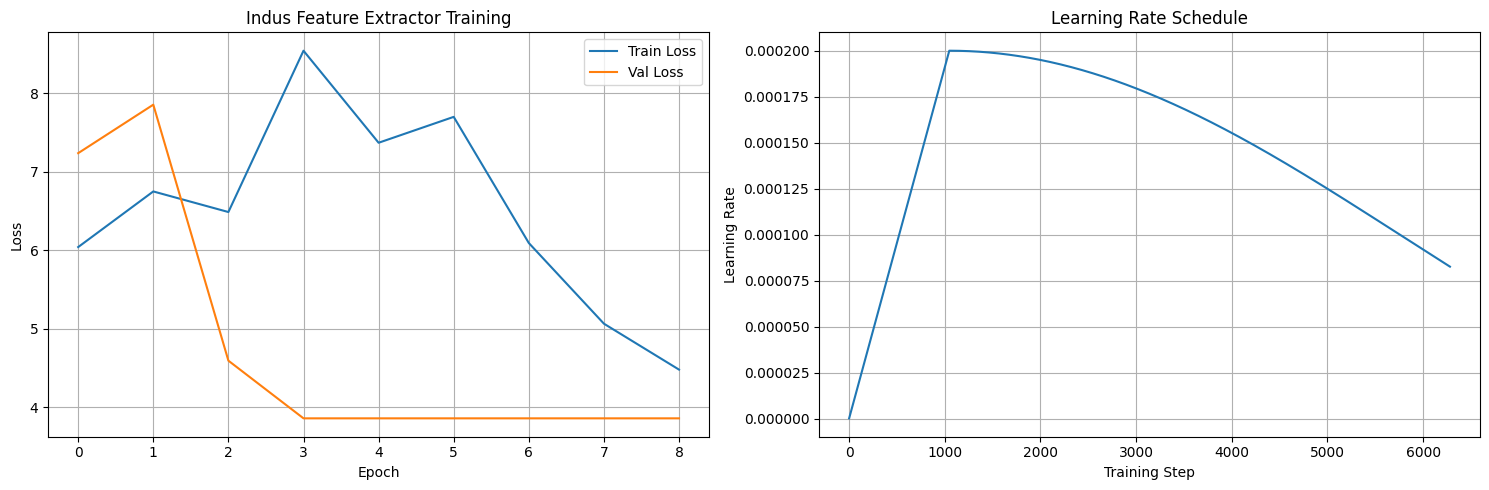

Training completed. Best validation loss: 3.8607 at epoch 5
Indus training complete!


In [ ]:
# Cell 1: Create validation loaders and train Indus feature extractor
print("Training feature extractor for Indus")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seed for reproducibility
set_seed(42)

# First, create validation loaders for each script
val_loaders = {}
for script_name in ['Indus', 'Proto-Cuneiform', 'Proto-Elamite']:
    path_key = script_name.replace("-", "_") if "-" in script_name else script_name
    script_path = dataset_paths.get(path_key, '')

    if os.path.exists(script_path):
        script_paths = load_image_paths(script_path)
        val_loader, _ = prepare_val_test_loaders(script_name, script_paths)
        val_loaders[script_name] = val_loader
        print(f"Created validation loader for {script_name}")

# Now train the Indus feature extractor
indus_extractor, indus_proj_head = train_feature_extractor(
    script_name='Indus',
    train_loader=augmented_train_loader,
    val_loader=val_loaders['Indus'],
    device=device,
    lr=2e-4,
    epochs=15,
    patience=4
)

# Save the model explicitly
torch.save({
    'model_state_dict': indus_extractor.state_dict(),
    'projection_head_state_dict': indus_proj_head.state_dict()
}, os.path.join(MODEL_DIR, 'Indus_feature_extractor_complete.pth'))

print("Indus training complete!")

## 4.3 Proto-Cuneiform Feature Extractor Training


Implementation of Proto-Cuneiform specialized encoder with path resolution and validation.

- **Architecture**: Identical Swin Transformer backbone with projection head
- **Path Resolution**: Multi-format key checking for dataset path access
- **Training Configuration**:
  - Consistent hyperparameters with Indus extractor (lr=2e-4, epochs=15)
  - Early stopping patience maintained at 4 epochs
  - Full augmentation pipeline integration
- **Corpus Processing**: Runtime validation of image availability
- **Model Persistence**: Complete model state with projection head saved to permanent storage

Training feature extractor for Proto-Cuneiform
Using device: cuda

=== DEBUG INFO ===
Keys in dataset_paths:
- 'Indus' (type: <class 'str'>) => '/content/drive/MyDrive/script_analysis/indus/'
- 'Proto-Cuneiform' (type: <class 'str'>) => '/content/drive/MyDrive/script_analysis/proto_cuneiform/'
- 'Proto-Elamite' (type: <class 'str'>) => '/content/drive/MyDrive/script_analysis/proto_elamite/'
- 'Naxi-Dongba' (type: <class 'str'>) => '/content/drive/MyDrive/script_analysis/naxi_dongba/'
- 'Old-Naxi' (type: <class 'str'>) => '/content/drive/MyDrive/script_analysis/old_naxi/'

Attempting to access with key 'Proto-Cuneiform'...
Success! Found path using key 'Proto-Cuneiform': /content/drive/MyDrive/script_analysis/proto_cuneiform/
Found 2089 images for Proto-Cuneiform
Successfully created validation loader for Proto-Cuneiform


Epoch 1/15 [Train]:   0%|          | 0/698 [00:00<?, ?it/s]

Train Batch: 10/698 | Loss: 11.1691 | LR: 0.000002
Train Batch: 20/698 | Loss: 10.5837 | LR: 0.000004
Train Batch: 30/698 | Loss: 10.5225 | LR: 0.000006
Train Batch: 40/698 | Loss: 11.0330 | LR: 0.000008
Train Batch: 50/698 | Loss: 8.1581 | LR: 0.000010
Train Batch: 60/698 | Loss: 8.4097 | LR: 0.000011
Train Batch: 70/698 | Loss: 7.7348 | LR: 0.000013
Train Batch: 80/698 | Loss: 7.4284 | LR: 0.000015
Train Batch: 90/698 | Loss: 6.3062 | LR: 0.000017
Train Batch: 100/698 | Loss: 6.4038 | LR: 0.000019
Train Batch: 110/698 | Loss: 5.5198 | LR: 0.000021
Train Batch: 120/698 | Loss: 5.8733 | LR: 0.000023
Train Batch: 130/698 | Loss: 5.2499 | LR: 0.000025
Train Batch: 140/698 | Loss: 5.2569 | LR: 0.000027
Train Batch: 150/698 | Loss: 6.0862 | LR: 0.000029
Train Batch: 160/698 | Loss: 5.4554 | LR: 0.000031
Train Batch: 170/698 | Loss: 5.4423 | LR: 0.000032
Train Batch: 180/698 | Loss: 5.7859 | LR: 0.000034
Train Batch: 190/698 | Loss: 5.1487 | LR: 0.000036
Train Batch: 200/698 | Loss: 5.3810 

Epoch 1/15 [Val]:   0%|          | 0/14 [00:00<?, ?it/s]


Epoch 1/15
Train Loss: 6.0406
Val Loss: 8.0278
Best model saved to /content/drive/MyDrive/script_analysis/models/Proto-Cuneiform_feature_extractor_best.pth


Epoch 2/15 [Train]:   0%|          | 0/698 [00:00<?, ?it/s]

Train Batch: 10/698 | Loss: 5.7627 | LR: 0.000135
Train Batch: 20/698 | Loss: 5.5865 | LR: 0.000137
Train Batch: 30/698 | Loss: 5.6824 | LR: 0.000139
Train Batch: 40/698 | Loss: 5.8796 | LR: 0.000141
Train Batch: 50/698 | Loss: 6.0396 | LR: 0.000143
Train Batch: 60/698 | Loss: 5.9417 | LR: 0.000145
Train Batch: 70/698 | Loss: 6.2590 | LR: 0.000147
Train Batch: 80/698 | Loss: 5.6300 | LR: 0.000149
Train Batch: 90/698 | Loss: 5.9947 | LR: 0.000151
Train Batch: 100/698 | Loss: 7.3899 | LR: 0.000152
Train Batch: 110/698 | Loss: 6.6080 | LR: 0.000154
Train Batch: 120/698 | Loss: 6.3934 | LR: 0.000156
Train Batch: 130/698 | Loss: 6.4050 | LR: 0.000158
Train Batch: 140/698 | Loss: 6.6195 | LR: 0.000160
Train Batch: 150/698 | Loss: 5.8991 | LR: 0.000162
Train Batch: 160/698 | Loss: 6.0907 | LR: 0.000164
Train Batch: 170/698 | Loss: 6.3605 | LR: 0.000166
Train Batch: 180/698 | Loss: 5.9314 | LR: 0.000168
Train Batch: 190/698 | Loss: 6.5952 | LR: 0.000170
Train Batch: 200/698 | Loss: 6.1200 | LR

Epoch 2/15 [Val]:   0%|          | 0/14 [00:00<?, ?it/s]


Epoch 2/15
Train Loss: 6.3845
Val Loss: 4.2390
Best model saved to /content/drive/MyDrive/script_analysis/models/Proto-Cuneiform_feature_extractor_best.pth


Epoch 3/15 [Train]:   0%|          | 0/698 [00:00<?, ?it/s]

Train Batch: 10/698 | Loss: 8.8005 | LR: 0.000199
Train Batch: 20/698 | Loss: 8.7684 | LR: 0.000199
Train Batch: 30/698 | Loss: 6.8030 | LR: 0.000199
Train Batch: 40/698 | Loss: 6.2805 | LR: 0.000199
Train Batch: 50/698 | Loss: 7.0841 | LR: 0.000199
Train Batch: 60/698 | Loss: 8.3526 | LR: 0.000199
Train Batch: 70/698 | Loss: 7.5564 | LR: 0.000199
Train Batch: 80/698 | Loss: 6.3645 | LR: 0.000199
Train Batch: 90/698 | Loss: 6.3784 | LR: 0.000199
Train Batch: 100/698 | Loss: 6.9302 | LR: 0.000199
Train Batch: 110/698 | Loss: 6.6178 | LR: 0.000199
Train Batch: 120/698 | Loss: 8.3685 | LR: 0.000199
Train Batch: 130/698 | Loss: 7.1594 | LR: 0.000199
Train Batch: 140/698 | Loss: 8.1982 | LR: 0.000199
Train Batch: 150/698 | Loss: 10.0373 | LR: 0.000199
Train Batch: 160/698 | Loss: 8.5729 | LR: 0.000199
Train Batch: 170/698 | Loss: 9.4224 | LR: 0.000199
Train Batch: 180/698 | Loss: 8.4648 | LR: 0.000198
Train Batch: 190/698 | Loss: 8.4055 | LR: 0.000198
Train Batch: 200/698 | Loss: 6.8161 | L

Epoch 3/15 [Val]:   0%|          | 0/14 [00:00<?, ?it/s]


Epoch 3/15
Train Loss: 7.2883
Val Loss: 3.8580
Best model saved to /content/drive/MyDrive/script_analysis/models/Proto-Cuneiform_feature_extractor_best.pth


Epoch 4/15 [Train]:   0%|          | 0/698 [00:00<?, ?it/s]

Train Batch: 10/698 | Loss: 9.8659 | LR: 0.000194
Train Batch: 20/698 | Loss: 9.7547 | LR: 0.000194
Train Batch: 30/698 | Loss: 9.7362 | LR: 0.000194
Train Batch: 40/698 | Loss: 9.0104 | LR: 0.000194
Train Batch: 50/698 | Loss: 8.4953 | LR: 0.000193
Train Batch: 60/698 | Loss: 8.6302 | LR: 0.000193
Train Batch: 70/698 | Loss: 9.4558 | LR: 0.000193
Train Batch: 80/698 | Loss: 8.3266 | LR: 0.000193
Train Batch: 90/698 | Loss: 8.6105 | LR: 0.000193
Train Batch: 100/698 | Loss: 8.7538 | LR: 0.000193
Train Batch: 110/698 | Loss: 9.3402 | LR: 0.000193
Train Batch: 120/698 | Loss: 8.3707 | LR: 0.000193
Train Batch: 130/698 | Loss: 7.7795 | LR: 0.000192
Train Batch: 140/698 | Loss: 6.5613 | LR: 0.000192
Train Batch: 150/698 | Loss: 6.6877 | LR: 0.000192
Train Batch: 160/698 | Loss: 6.9159 | LR: 0.000192
Train Batch: 170/698 | Loss: 7.1352 | LR: 0.000192
Train Batch: 180/698 | Loss: 6.2293 | LR: 0.000192
Train Batch: 190/698 | Loss: 7.8060 | LR: 0.000192
Train Batch: 200/698 | Loss: 6.5842 | LR

Epoch 4/15 [Val]:   0%|          | 0/14 [00:00<?, ?it/s]


Epoch 4/15
Train Loss: 7.3013
Val Loss: 3.8460
Best model saved to /content/drive/MyDrive/script_analysis/models/Proto-Cuneiform_feature_extractor_best.pth


Epoch 5/15 [Train]:   0%|          | 0/698 [00:00<?, ?it/s]

Train Batch: 10/698 | Loss: 8.8359 | LR: 0.000183
Train Batch: 20/698 | Loss: 8.4954 | LR: 0.000183
Train Batch: 30/698 | Loss: 7.9569 | LR: 0.000183
Train Batch: 40/698 | Loss: 7.0768 | LR: 0.000183
Train Batch: 50/698 | Loss: 7.9051 | LR: 0.000183
Train Batch: 60/698 | Loss: 5.7880 | LR: 0.000182
Train Batch: 70/698 | Loss: 6.6089 | LR: 0.000182
Train Batch: 80/698 | Loss: 6.9797 | LR: 0.000182
Train Batch: 90/698 | Loss: 5.6877 | LR: 0.000182
Train Batch: 100/698 | Loss: 5.7461 | LR: 0.000182
Train Batch: 110/698 | Loss: 5.9607 | LR: 0.000181
Train Batch: 120/698 | Loss: 5.2581 | LR: 0.000181
Train Batch: 130/698 | Loss: 5.5953 | LR: 0.000181
Train Batch: 140/698 | Loss: 6.3058 | LR: 0.000181
Train Batch: 150/698 | Loss: 5.6048 | LR: 0.000181
Train Batch: 160/698 | Loss: 9.1363 | LR: 0.000181
Train Batch: 170/698 | Loss: 6.1892 | LR: 0.000180
Train Batch: 180/698 | Loss: 6.3880 | LR: 0.000180
Train Batch: 190/698 | Loss: 6.8869 | LR: 0.000180
Train Batch: 200/698 | Loss: 5.0614 | LR

Epoch 5/15 [Val]:   0%|          | 0/14 [00:00<?, ?it/s]


Epoch 5/15
Train Loss: 6.2828
Val Loss: 10.0067
No improvement for 1 epochs


Epoch 6/15 [Train]:   0%|          | 0/698 [00:00<?, ?it/s]

Train Batch: 10/698 | Loss: 6.0948 | LR: 0.000168
Train Batch: 20/698 | Loss: 5.7614 | LR: 0.000168
Train Batch: 30/698 | Loss: 6.4792 | LR: 0.000168
Train Batch: 40/698 | Loss: 6.1752 | LR: 0.000168
Train Batch: 50/698 | Loss: 5.1836 | LR: 0.000167
Train Batch: 60/698 | Loss: 5.7808 | LR: 0.000167
Train Batch: 70/698 | Loss: 5.7013 | LR: 0.000167
Train Batch: 80/698 | Loss: 5.2749 | LR: 0.000167
Train Batch: 90/698 | Loss: 6.0709 | LR: 0.000166
Train Batch: 100/698 | Loss: 5.4726 | LR: 0.000166
Train Batch: 110/698 | Loss: 5.8963 | LR: 0.000166
Train Batch: 120/698 | Loss: 6.5587 | LR: 0.000166
Train Batch: 130/698 | Loss: 6.7200 | LR: 0.000165
Train Batch: 140/698 | Loss: 6.9456 | LR: 0.000165
Train Batch: 150/698 | Loss: 7.1943 | LR: 0.000165
Train Batch: 160/698 | Loss: 5.5425 | LR: 0.000165
Train Batch: 170/698 | Loss: 5.7374 | LR: 0.000164
Train Batch: 180/698 | Loss: 4.9983 | LR: 0.000164
Train Batch: 190/698 | Loss: 5.4828 | LR: 0.000164
Train Batch: 200/698 | Loss: 5.7776 | LR

Epoch 6/15 [Val]:   0%|          | 0/14 [00:00<?, ?it/s]


Epoch 6/15
Train Loss: 5.9404
Val Loss: 9.4502
No improvement for 2 epochs


Epoch 7/15 [Train]:   0%|          | 0/698 [00:00<?, ?it/s]

Train Batch: 10/698 | Loss: 5.3462 | LR: 0.000150
Train Batch: 20/698 | Loss: 4.9292 | LR: 0.000149
Train Batch: 30/698 | Loss: 5.2046 | LR: 0.000149
Train Batch: 40/698 | Loss: 5.7888 | LR: 0.000149
Train Batch: 50/698 | Loss: 5.4823 | LR: 0.000149
Train Batch: 60/698 | Loss: 5.3989 | LR: 0.000148
Train Batch: 70/698 | Loss: 5.8238 | LR: 0.000148
Train Batch: 80/698 | Loss: 5.5459 | LR: 0.000148
Train Batch: 90/698 | Loss: 5.4512 | LR: 0.000147
Train Batch: 100/698 | Loss: 5.0537 | LR: 0.000147
Train Batch: 110/698 | Loss: 5.2948 | LR: 0.000147
Train Batch: 120/698 | Loss: 5.5354 | LR: 0.000146
Train Batch: 130/698 | Loss: 5.0709 | LR: 0.000146
Train Batch: 140/698 | Loss: 4.7481 | LR: 0.000146
Train Batch: 150/698 | Loss: 6.0968 | LR: 0.000146
Train Batch: 160/698 | Loss: 5.6362 | LR: 0.000145
Train Batch: 170/698 | Loss: 5.5761 | LR: 0.000145
Train Batch: 180/698 | Loss: 5.2225 | LR: 0.000145
Train Batch: 190/698 | Loss: 5.8500 | LR: 0.000144
Train Batch: 200/698 | Loss: 5.4499 | LR

Epoch 7/15 [Val]:   0%|          | 0/14 [00:00<?, ?it/s]


Epoch 7/15
Train Loss: 5.3068
Val Loss: 9.9586
No improvement for 3 epochs


Epoch 8/15 [Train]:   0%|          | 0/698 [00:00<?, ?it/s]

Train Batch: 10/698 | Loss: 5.5223 | LR: 0.000128
Train Batch: 20/698 | Loss: 4.9567 | LR: 0.000128
Train Batch: 30/698 | Loss: 5.2937 | LR: 0.000128
Train Batch: 40/698 | Loss: 5.2228 | LR: 0.000127
Train Batch: 50/698 | Loss: 5.0986 | LR: 0.000127
Train Batch: 60/698 | Loss: 5.7168 | LR: 0.000127
Train Batch: 70/698 | Loss: 5.6626 | LR: 0.000126
Train Batch: 80/698 | Loss: 5.1193 | LR: 0.000126
Train Batch: 90/698 | Loss: 5.9305 | LR: 0.000126
Train Batch: 100/698 | Loss: 5.2442 | LR: 0.000125
Train Batch: 110/698 | Loss: 4.7585 | LR: 0.000125
Train Batch: 120/698 | Loss: 5.3812 | LR: 0.000125
Train Batch: 130/698 | Loss: 5.6969 | LR: 0.000125
Train Batch: 140/698 | Loss: 5.2598 | LR: 0.000124
Train Batch: 150/698 | Loss: 5.4526 | LR: 0.000124
Train Batch: 160/698 | Loss: 5.0471 | LR: 0.000124
Train Batch: 170/698 | Loss: 5.1201 | LR: 0.000123
Train Batch: 180/698 | Loss: 5.3231 | LR: 0.000123
Train Batch: 190/698 | Loss: 4.8932 | LR: 0.000123
Train Batch: 200/698 | Loss: 5.5980 | LR

Epoch 8/15 [Val]:   0%|          | 0/14 [00:00<?, ?it/s]


Epoch 8/15
Train Loss: 5.2677
Val Loss: 8.7522
No improvement for 4 epochs
Early stopping triggered after epoch 8
Final model saved to /content/drive/MyDrive/script_analysis/models/Proto-Cuneiform_feature_extractor_final.pth


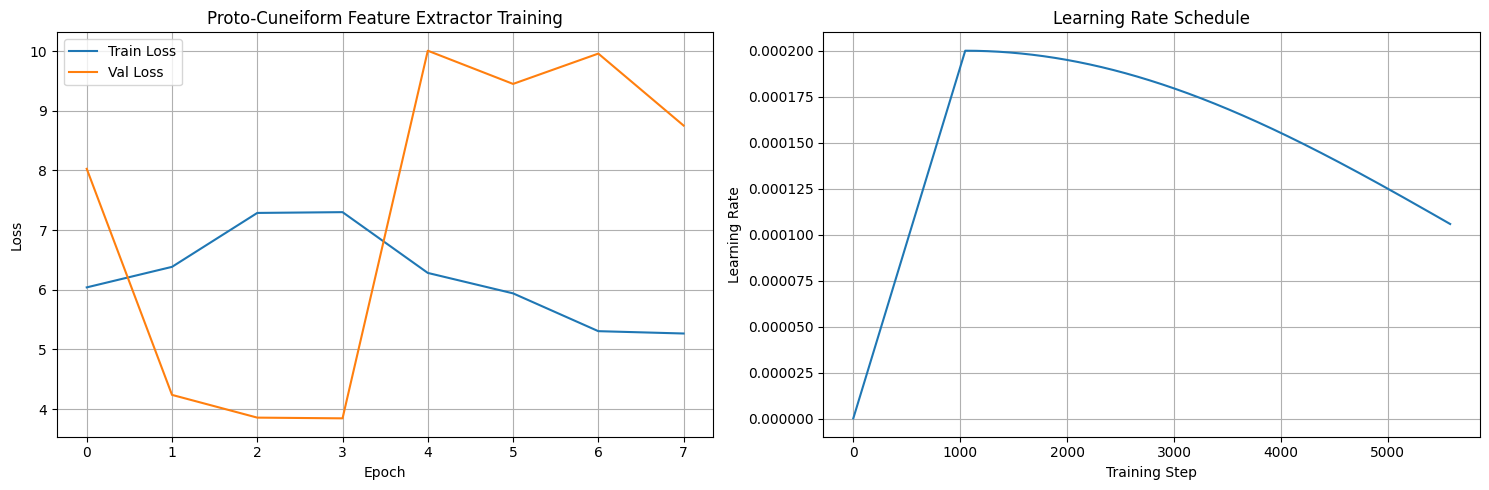

Training completed. Best validation loss: 3.8460 at epoch 4
Proto-Cuneiform training complete!


In [ ]:
# Cell 2: Debug and train Proto-Cuneiform feature extractor
print("Training feature extractor for Proto-Cuneiform")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seed for reproducibility
set_seed(42)

# Debug the dataset_paths dictionary
print("\n=== DEBUG INFO ===")
print("Keys in dataset_paths:")
for key in dataset_paths.keys():
    print(f"- '{key}' (type: {type(key)}) => '{dataset_paths[key]}'")

# Try direct key access
script_name = 'Proto-Cuneiform'
print(f"\nAttempting to access with key '{script_name}'...")

# Try these different key formats
keys_to_try = [
    'Proto-Cuneiform',
    'Proto_Cuneiform',
    'Proto Cuneiform',
    'ProtoCuneiform'
]

script_path = None
for key in keys_to_try:
    if key in dataset_paths:
        script_path = dataset_paths[key]
        print(f"Success! Found path using key '{key}': {script_path}")
        break

# If we found a valid path, proceed with training
if script_path and os.path.exists(script_path):
    script_paths = load_image_paths(script_path)
    if script_paths and len(script_paths) > 0:
        print(f"Found {len(script_paths)} images for {script_name}")
        val_loader, _ = prepare_val_test_loaders(script_name, script_paths)

        # Create val_loaders if it doesn't exist
        if 'val_loaders' not in locals() or 'val_loaders' not in globals():
            val_loaders = {}

        val_loaders[script_name] = val_loader
        print(f"Successfully created validation loader for {script_name}")

        # Now train the Proto-Cuneiform feature extractor
        proto_cuneiform_extractor, proto_cuneiform_proj_head = train_feature_extractor(
            script_name=script_name,
            train_loader=augmented_train_loader,
            val_loader=val_loader,  # Use the directly created val_loader
            device=device,
            lr=2e-4,
            epochs=15,
            patience=4
        )

        # Save the model explicitly
        torch.save({
            'model_state_dict': proto_cuneiform_extractor.state_dict(),
            'projection_head_state_dict': proto_cuneiform_proj_head.state_dict()
        }, os.path.join(MODEL_DIR, f'{script_name}_feature_extractor_complete.pth'))

        print(f"{script_name} training complete!")
    else:
        print(f"ERROR: No images found in {script_path}")
else:
    print("ERROR: Could not find a valid path for Proto-Cuneiform")

## 4.4 Proto-Elamite Feature Extractor Training


Implementation of Proto-Elamite specialized encoder with robust path resolution.

- **Architecture**: Consistent Swin Transformer architecture with projection head
- **Path Resolution**: Multi-key format checking for reliable dataset access
- **Training Configuration**:
  - Standard hyperparameters (lr=2e-4, epochs=15, patience=4)
  - Full integration with augmentation pipeline
  - Deterministic initialization with fixed random seed
- **Validation Strategy**: Split-based performance monitoring with early stopping
- **Model Persistence**: Complete model state with projection head exported to storage

Training feature extractor for Proto-Elamite
Using device: cuda

=== DEBUG INFO ===
Keys in dataset_paths:
- 'Indus' (type: <class 'str'>) => '/content/drive/MyDrive/script_analysis/indus/'
- 'Proto-Cuneiform' (type: <class 'str'>) => '/content/drive/MyDrive/script_analysis/proto_cuneiform/'
- 'Proto-Elamite' (type: <class 'str'>) => '/content/drive/MyDrive/script_analysis/proto_elamite/'
- 'Naxi-Dongba' (type: <class 'str'>) => '/content/drive/MyDrive/script_analysis/naxi_dongba/'
- 'Old-Naxi' (type: <class 'str'>) => '/content/drive/MyDrive/script_analysis/old_naxi/'

Attempting to access with key 'Proto-Elamite'...
Success! Found path using key 'Proto-Elamite': /content/drive/MyDrive/script_analysis/proto_elamite/
Found 1510 images for Proto-Elamite
Successfully created validation loader for Proto-Elamite


Epoch 1/15 [Train]:   0%|          | 0/698 [00:00<?, ?it/s]

Train Batch: 10/698 | Loss: 11.3803 | LR: 0.000002
Train Batch: 20/698 | Loss: 10.6284 | LR: 0.000004
Train Batch: 30/698 | Loss: 10.1987 | LR: 0.000006
Train Batch: 40/698 | Loss: 10.6545 | LR: 0.000008
Train Batch: 50/698 | Loss: 8.1602 | LR: 0.000010
Train Batch: 60/698 | Loss: 8.2953 | LR: 0.000011
Train Batch: 70/698 | Loss: 7.5687 | LR: 0.000013
Train Batch: 80/698 | Loss: 6.7751 | LR: 0.000015
Train Batch: 90/698 | Loss: 6.3257 | LR: 0.000017
Train Batch: 100/698 | Loss: 6.4697 | LR: 0.000019
Train Batch: 110/698 | Loss: 4.9615 | LR: 0.000021
Train Batch: 120/698 | Loss: 5.1946 | LR: 0.000023
Train Batch: 130/698 | Loss: 5.5336 | LR: 0.000025
Train Batch: 140/698 | Loss: 5.2487 | LR: 0.000027
Train Batch: 150/698 | Loss: 5.3367 | LR: 0.000029
Train Batch: 160/698 | Loss: 5.5154 | LR: 0.000031
Train Batch: 170/698 | Loss: 5.2980 | LR: 0.000032
Train Batch: 180/698 | Loss: 5.4519 | LR: 0.000034
Train Batch: 190/698 | Loss: 4.9943 | LR: 0.000036
Train Batch: 200/698 | Loss: 5.6925 

Epoch 1/15 [Val]:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 1/15
Train Loss: 6.0249
Val Loss: 6.2196
Best model saved to /content/drive/MyDrive/script_analysis/models/Proto-Elamite_feature_extractor_best.pth


Epoch 2/15 [Train]:   0%|          | 0/698 [00:00<?, ?it/s]

Train Batch: 10/698 | Loss: 5.4590 | LR: 0.000135
Train Batch: 20/698 | Loss: 5.2447 | LR: 0.000137
Train Batch: 30/698 | Loss: 6.2262 | LR: 0.000139
Train Batch: 40/698 | Loss: 5.9424 | LR: 0.000141
Train Batch: 50/698 | Loss: 6.1029 | LR: 0.000143
Train Batch: 60/698 | Loss: 5.3522 | LR: 0.000145
Train Batch: 70/698 | Loss: 6.3656 | LR: 0.000147
Train Batch: 80/698 | Loss: 7.4887 | LR: 0.000149
Train Batch: 90/698 | Loss: 6.0145 | LR: 0.000151
Train Batch: 100/698 | Loss: 6.4227 | LR: 0.000152
Train Batch: 110/698 | Loss: 5.6943 | LR: 0.000154
Train Batch: 120/698 | Loss: 5.7398 | LR: 0.000156
Train Batch: 130/698 | Loss: 6.1482 | LR: 0.000158
Train Batch: 140/698 | Loss: 6.4350 | LR: 0.000160
Train Batch: 150/698 | Loss: 6.4004 | LR: 0.000162
Train Batch: 160/698 | Loss: 6.5802 | LR: 0.000164
Train Batch: 170/698 | Loss: 6.3379 | LR: 0.000166
Train Batch: 180/698 | Loss: 6.0076 | LR: 0.000168
Train Batch: 190/698 | Loss: 7.1859 | LR: 0.000170
Train Batch: 200/698 | Loss: 7.5970 | LR

Epoch 2/15 [Val]:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 2/15
Train Loss: 6.6481
Val Loss: 4.0583
Best model saved to /content/drive/MyDrive/script_analysis/models/Proto-Elamite_feature_extractor_best.pth


Epoch 3/15 [Train]:   0%|          | 0/698 [00:00<?, ?it/s]

Train Batch: 10/698 | Loss: 8.4201 | LR: 0.000199
Train Batch: 20/698 | Loss: 8.9597 | LR: 0.000199
Train Batch: 30/698 | Loss: 7.7777 | LR: 0.000199
Train Batch: 40/698 | Loss: 7.3752 | LR: 0.000199
Train Batch: 50/698 | Loss: 6.5786 | LR: 0.000199
Train Batch: 60/698 | Loss: 5.7159 | LR: 0.000199
Train Batch: 70/698 | Loss: 6.7051 | LR: 0.000199
Train Batch: 80/698 | Loss: 5.7658 | LR: 0.000199
Train Batch: 90/698 | Loss: 6.2991 | LR: 0.000199
Train Batch: 100/698 | Loss: 6.6570 | LR: 0.000199
Train Batch: 110/698 | Loss: 7.0338 | LR: 0.000199
Train Batch: 120/698 | Loss: 6.8470 | LR: 0.000199
Train Batch: 130/698 | Loss: 6.0964 | LR: 0.000199
Train Batch: 140/698 | Loss: 6.4760 | LR: 0.000199
Train Batch: 150/698 | Loss: 6.6283 | LR: 0.000199
Train Batch: 160/698 | Loss: 6.4031 | LR: 0.000199
Train Batch: 170/698 | Loss: 6.5501 | LR: 0.000199
Train Batch: 180/698 | Loss: 6.0950 | LR: 0.000198
Train Batch: 190/698 | Loss: 6.4989 | LR: 0.000198
Train Batch: 200/698 | Loss: 7.5901 | LR

Epoch 3/15 [Val]:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 3/15
Train Loss: 6.6318
Val Loss: 11.2973
No improvement for 1 epochs


Epoch 4/15 [Train]:   0%|          | 0/698 [00:00<?, ?it/s]

Train Batch: 10/698 | Loss: 7.5305 | LR: 0.000194
Train Batch: 20/698 | Loss: 8.5579 | LR: 0.000194
Train Batch: 30/698 | Loss: 7.1345 | LR: 0.000194
Train Batch: 40/698 | Loss: 7.3367 | LR: 0.000194
Train Batch: 50/698 | Loss: 6.1084 | LR: 0.000193
Train Batch: 60/698 | Loss: 5.9892 | LR: 0.000193
Train Batch: 70/698 | Loss: 5.9026 | LR: 0.000193
Train Batch: 80/698 | Loss: 6.1134 | LR: 0.000193
Train Batch: 90/698 | Loss: 6.4743 | LR: 0.000193
Train Batch: 100/698 | Loss: 6.6916 | LR: 0.000193
Train Batch: 110/698 | Loss: 6.3663 | LR: 0.000193
Train Batch: 120/698 | Loss: 6.8045 | LR: 0.000193
Train Batch: 130/698 | Loss: 5.2723 | LR: 0.000192
Train Batch: 140/698 | Loss: 6.1265 | LR: 0.000192
Train Batch: 150/698 | Loss: 6.5688 | LR: 0.000192
Train Batch: 160/698 | Loss: 6.6817 | LR: 0.000192
Train Batch: 170/698 | Loss: 5.9023 | LR: 0.000192
Train Batch: 180/698 | Loss: 7.1141 | LR: 0.000192
Train Batch: 190/698 | Loss: 6.2908 | LR: 0.000192
Train Batch: 200/698 | Loss: 8.3243 | LR

Epoch 4/15 [Val]:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 4/15
Train Loss: 6.3077
Val Loss: 11.3845
No improvement for 2 epochs


Epoch 5/15 [Train]:   0%|          | 0/698 [00:00<?, ?it/s]

Train Batch: 10/698 | Loss: 5.8538 | LR: 0.000183
Train Batch: 20/698 | Loss: 6.5892 | LR: 0.000183
Train Batch: 30/698 | Loss: 6.8913 | LR: 0.000183
Train Batch: 40/698 | Loss: 6.3569 | LR: 0.000183
Train Batch: 50/698 | Loss: 6.0886 | LR: 0.000183
Train Batch: 60/698 | Loss: 5.9827 | LR: 0.000182
Train Batch: 70/698 | Loss: 6.1488 | LR: 0.000182
Train Batch: 80/698 | Loss: 5.9809 | LR: 0.000182
Train Batch: 90/698 | Loss: 6.9634 | LR: 0.000182
Train Batch: 100/698 | Loss: 6.1221 | LR: 0.000182
Train Batch: 110/698 | Loss: 5.4996 | LR: 0.000181
Train Batch: 120/698 | Loss: 6.5704 | LR: 0.000181
Train Batch: 130/698 | Loss: 5.2665 | LR: 0.000181
Train Batch: 140/698 | Loss: 5.4799 | LR: 0.000181
Train Batch: 150/698 | Loss: 4.8344 | LR: 0.000181
Train Batch: 160/698 | Loss: 6.2114 | LR: 0.000181
Train Batch: 170/698 | Loss: 5.0692 | LR: 0.000180
Train Batch: 180/698 | Loss: 6.2072 | LR: 0.000180
Train Batch: 190/698 | Loss: 5.5784 | LR: 0.000180
Train Batch: 200/698 | Loss: 6.3569 | LR

Epoch 5/15 [Val]:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 5/15
Train Loss: 6.0625
Val Loss: 9.6300
No improvement for 3 epochs


Epoch 6/15 [Train]:   0%|          | 0/698 [00:00<?, ?it/s]

Train Batch: 10/698 | Loss: 6.4567 | LR: 0.000168
Train Batch: 20/698 | Loss: 5.5329 | LR: 0.000168
Train Batch: 30/698 | Loss: 5.6668 | LR: 0.000168
Train Batch: 40/698 | Loss: 5.3762 | LR: 0.000168
Train Batch: 50/698 | Loss: 7.1257 | LR: 0.000167
Train Batch: 60/698 | Loss: 6.0503 | LR: 0.000167
Train Batch: 70/698 | Loss: 6.3146 | LR: 0.000167
Train Batch: 80/698 | Loss: 6.6229 | LR: 0.000167
Train Batch: 90/698 | Loss: 6.0300 | LR: 0.000166
Train Batch: 100/698 | Loss: 6.2744 | LR: 0.000166
Train Batch: 110/698 | Loss: 6.5589 | LR: 0.000166
Train Batch: 120/698 | Loss: 6.9527 | LR: 0.000166
Train Batch: 130/698 | Loss: 7.5752 | LR: 0.000165
Train Batch: 140/698 | Loss: 6.3667 | LR: 0.000165
Train Batch: 150/698 | Loss: 6.0260 | LR: 0.000165
Train Batch: 160/698 | Loss: 6.8016 | LR: 0.000165
Train Batch: 170/698 | Loss: 5.6567 | LR: 0.000164
Train Batch: 180/698 | Loss: 6.0233 | LR: 0.000164
Train Batch: 190/698 | Loss: 5.8581 | LR: 0.000164
Train Batch: 200/698 | Loss: 6.4210 | LR

Epoch 6/15 [Val]:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 6/15
Train Loss: 5.7969
Val Loss: 11.5154
No improvement for 4 epochs
Early stopping triggered after epoch 6
Final model saved to /content/drive/MyDrive/script_analysis/models/Proto-Elamite_feature_extractor_final.pth


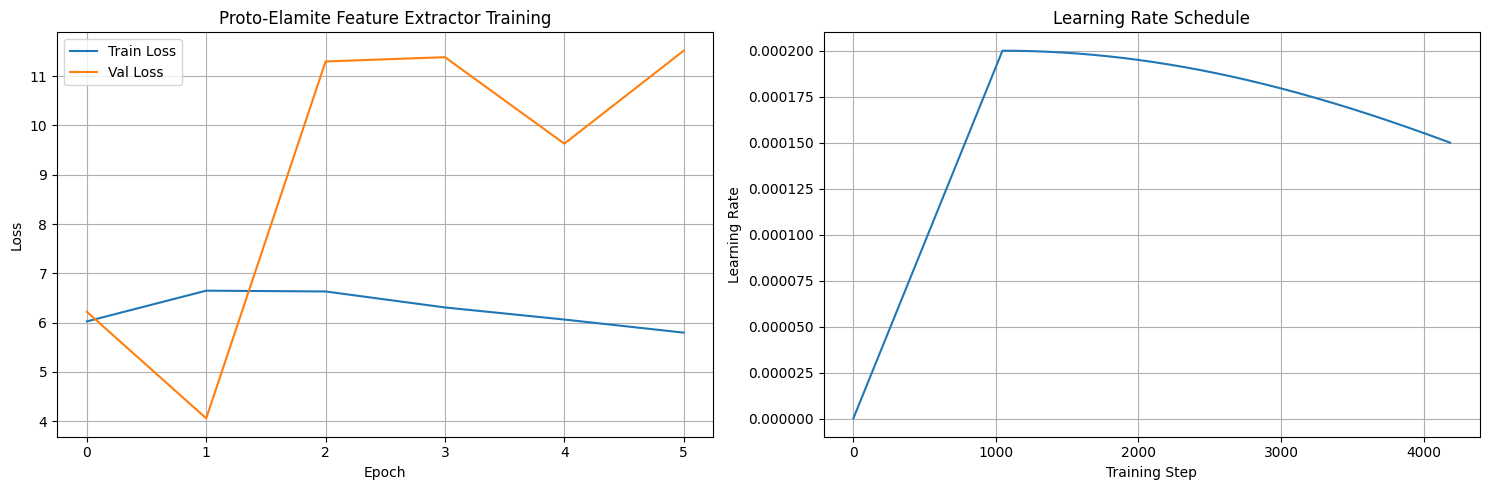

Training completed. Best validation loss: 4.0583 at epoch 2
Proto-Elamite training complete!


In [ ]:
# Cell 2: Debug and train Proto-Elamite feature extractor
print("Training feature extractor for Proto-Elamite")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seed for reproducibility
set_seed(42)

# Debug the dataset_paths dictionary
print("\n=== DEBUG INFO ===")
print("Keys in dataset_paths:")
for key in dataset_paths.keys():
    print(f"- '{key}' (type: {type(key)}) => '{dataset_paths[key]}'")

# Try direct key access
script_name = 'Proto-Elamite'
print(f"\nAttempting to access with key '{script_name}'...")

# Try these different key formats
keys_to_try = [
    'Proto-Elamite',
    'Proto_Elamite',
    'Proto Elamite',
    'ProtoElamite'
]

script_path = None
for key in keys_to_try:
    if key in dataset_paths:
        script_path = dataset_paths[key]
        print(f"Success! Found path using key '{key}': {script_path}")
        break

# If we found a valid path, proceed with training
if script_path and os.path.exists(script_path):
    script_paths = load_image_paths(script_path)
    if script_paths and len(script_paths) > 0:
        print(f"Found {len(script_paths)} images for {script_name}")
        val_loader, _ = prepare_val_test_loaders(script_name, script_paths)

        # Create val_loaders if it doesn't exist
        if 'val_loaders' not in locals() or 'val_loaders' not in globals():
            val_loaders = {}

        val_loaders[script_name] = val_loader
        print(f"Successfully created validation loader for {script_name}")

        # Now train the Proto-Elamite feature extractor
        proto_elamite_extractor, proto_elamite_proj_head = train_feature_extractor(
            script_name=script_name,
            train_loader=augmented_train_loader,
            val_loader=val_loader,  # Use the directly created val_loader
            device=device,
            lr=2e-4,
            epochs=15,
            patience=4
        )

        # Save the model explicitly
        torch.save({
            'model_state_dict': proto_elamite_extractor.state_dict(),
            'projection_head_state_dict': proto_elamite_proj_head.state_dict()
        }, os.path.join(MODEL_DIR, f'{script_name}_feature_extractor_complete.pth'))

        print(f"{script_name} training complete!")
    else:
        print(f"ERROR: No images found in {script_path}")
else:
    print("ERROR: Could not find a valid path for Proto-Elamite")

# **5. Embedding Extraction and Cross-Script Analysis**

Extract Feature Embeddings from Trained Models

In [21]:
# Step 2: Extract Feature Embeddings - Modified for Naxi Dongba, Old Naxi, and TYC
print("Extracting feature embeddings from trained models...")

# Define the target scripts to analyze
target_scripts = ['Naxi Dongba', 'Old Naxi', 'Tibetan-Yi Corridor']
source_models = ['Indus', 'Proto-Cuneiform', 'Proto-Elamite']

# Prepare loaders for all target scripts
extraction_loaders = {}
test_transform = get_test_transforms(img_size=224)

# Create Naxi Dongba loader
if os.path.exists(NAXI_DONGBA_PATH):
    naxi_dongba_paths = load_image_paths(NAXI_DONGBA_PATH)
    if naxi_dongba_paths:
        naxi_dataset = ScriptDataset(naxi_dongba_paths, test_transform, script_type='Naxi Dongba', denoise_types=[])
        extraction_loaders['Naxi Dongba'] = DataLoader(naxi_dataset, batch_size=32, shuffle=False, num_workers=2)
        print(f"Created Naxi Dongba extraction loader with {len(naxi_dongba_paths)} images")

# Create Old Naxi loader
if os.path.exists(OLD_NAXI_PATH):
    old_naxi_paths = load_image_paths(OLD_NAXI_PATH)
    if old_naxi_paths:
        old_naxi_dataset = ScriptDataset(old_naxi_paths, test_transform, script_type='Old Naxi', denoise_types=["Old Naxi"])
        extraction_loaders['Old Naxi'] = DataLoader(old_naxi_dataset, batch_size=32, shuffle=False, num_workers=2)
        print(f"Created Old Naxi extraction loader with {len(old_naxi_paths)} images")

# Create TYC loader (combined from all TYC subfolders)
if os.path.exists(TYC_PATH):
    tyc_paths = []
    for subfolder in ['yi', 'ba-shu', 'old_naxi']:
        subfolder_path = os.path.join(TYC_PATH, subfolder)
        if os.path.exists(subfolder_path):
            subfolder_paths = load_image_paths(subfolder_path)
            tyc_paths.extend(subfolder_paths)

    if tyc_paths:
        tyc_dataset = ScriptDataset(tyc_paths, test_transform, script_type='Tibetan-Yi Corridor', denoise_types=[])
        extraction_loaders['Tibetan-Yi Corridor'] = DataLoader(tyc_dataset, batch_size=32, shuffle=False, num_workers=2)
        print(f"Created TYC extraction loader with {len(tyc_paths)} images")

# Load the trained feature extractor models
models = {}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for model_name in source_models:
    model_path = os.path.join(MODEL_DIR, f"{model_name}_feature_extractor_best.pth")
    if not os.path.exists(model_path):
        print(f"Warning: Could not find model at {model_path}")
        continue

    # Initialize the model
    model = ScriptFeatureExtractor(
        model_name='swin_base_patch4_window7_224',
        pretrained=False
    ).to(device)

    # Load trained weights
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    models[model_name] = model
    print(f"Loaded {model_name} model from {model_path}")

# Extract embeddings for each target script using each trained model
all_embeddings = {}

for model_name, model in models.items():
    print(f"\nExtracting embeddings using {model_name} model:")

    # Dictionary to store embeddings for this model
    model_embeddings = {}

    for script_name, loader in extraction_loaders.items():
        print(f"  Processing {script_name}...")
        script_embeddings = []

        with torch.no_grad():
            for inputs, _ in tqdm(loader):
                inputs = inputs.to(device)
                features = model.extract_features(inputs)
                script_embeddings.append(features.cpu().numpy())

        if script_embeddings:
            model_embeddings[script_name] = np.vstack(script_embeddings)
            print(f"    Extracted {len(model_embeddings[script_name])} embeddings")

    all_embeddings[model_name] = model_embeddings

# Save the embeddings
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
np.save(os.path.join(RESULTS_DIR, f"script_embeddings_{timestamp}.npy"), all_embeddings)
print(f"Embeddings saved to {RESULTS_DIR}/script_embeddings_{timestamp}.npy")

Extracting feature embeddings from trained models...
Created Naxi Dongba extraction loader with 2122 images
Created Old Naxi extraction loader with 253 images
Created TYC extraction loader with 8766 images


<ipython-input-21-7606ba91c02f>:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


Loaded Indus model from /content/drive/MyDrive/script_analysis/models/Indus_feature_extractor_best.pth
Loaded Proto-Cuneiform model from /content/drive/MyDrive/script_analysis/models/Proto-Cuneiform_feature_extractor_best.pth
Loaded Proto-Elamite model from /content/drive/MyDrive/script_analysis/models/Proto-Elamite_feature_extractor_best.pth

Extracting embeddings using Indus model:
  Processing Naxi Dongba...


  0%|          | 0/67 [00:00<?, ?it/s]

    Extracted 2122 embeddings
  Processing Old Naxi...


  0%|          | 0/8 [00:00<?, ?it/s]

    Extracted 253 embeddings
  Processing Tibetan-Yi Corridor...


  0%|          | 0/274 [00:00<?, ?it/s]

    Extracted 8766 embeddings

Extracting embeddings using Proto-Cuneiform model:
  Processing Naxi Dongba...


  0%|          | 0/67 [00:00<?, ?it/s]

    Extracted 2122 embeddings
  Processing Old Naxi...


  0%|          | 0/8 [00:00<?, ?it/s]

    Extracted 253 embeddings
  Processing Tibetan-Yi Corridor...


  0%|          | 0/274 [00:00<?, ?it/s]

    Extracted 8766 embeddings

Extracting embeddings using Proto-Elamite model:
  Processing Naxi Dongba...


  0%|          | 0/67 [00:00<?, ?it/s]

    Extracted 2122 embeddings
  Processing Old Naxi...


  0%|          | 0/8 [00:00<?, ?it/s]

    Extracted 253 embeddings
  Processing Tibetan-Yi Corridor...


  0%|          | 0/274 [00:00<?, ?it/s]

    Extracted 8766 embeddings
Embeddings saved to /content/drive/MyDrive/script_analysis/results/script_embeddings_20250303_165458.npy
